# Data Exploration
Basic initial exploration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 139)
plt.style.use('ggplot')

In [3]:
df = pd.read_parquet('accumulated_weekend_data_2023_02_27.parquet')
df = df.drop(df[df['run_id'] < 5.0].index) # Keep runs 5 and above
df

ImportError: Unable to find a usable engine; tried using: 'pyarrow', 'fastparquet'.
A suitable version of pyarrow or fastparquet is required for parquet support.
Trying to import the above resulted in these errors:
 - Missing optional dependency 'pyarrow'. pyarrow is required for parquet support. Use pip or conda to install pyarrow.
 - Missing optional dependency 'fastparquet'. fastparquet is required for parquet support. Use pip or conda to install fastparquet.

![run_info](run_info.png)

# Key Features
fcv1_i, bias_v, bias_i, inj_mbar, run_id (start_time, stop_time)?

In [3]:
rows = ["run_id", "fcv1_i_mean", "bias_v_mean", "bias_i_mean", "inj_mbar_mean", "start_time", "stop_time"]
features = rows[1:5]

In [4]:
tiny_df = df[rows]
tiny_df

run_id  fcv1_i_mean  bias_v_mean  bias_i_mean  inj_mbar_mean  \
2490      5.0     0.000408    30.367090     7.752190   1.631546e-07   
2491      5.0     0.000182    11.886959     0.191699   1.799325e-07   
2492      5.0     0.000416    84.668518     7.286177   1.477675e-07   
2493      5.0     0.000357    84.572268     5.439768   1.352869e-07   
2494      5.0     0.000196    84.459976     4.143592   1.118232e-07   
...       ...          ...          ...          ...            ...   
12939    10.0     0.000131    23.749855    10.338125   1.779659e-07   
12940    10.0     0.000433    64.127014    15.736986   1.440222e-07   
12941    10.0     0.000136    24.086733    10.366198   1.768910e-07   
12942    10.0     0.000074    12.825403     3.896548   1.875515e-07   
12943    10.0     0.000182    28.570410    11.057599   1.743328e-07   

         start_time     stop_time  
2490   1.662167e+09  1.662167e+09  
2491   1.662167e+09  1.662168e+09  
2492   1.662168e+09  1.662168e+09  
2493   1.662168e+09  1.662168e+09  
2494   1.662169e+09  1.662169e+09  
...             ...           ...  
12939  1.672848e+09  1.672848e+09  
12940  1.672848e+09  1.672848e+09  
12941  1.672848e+09  1.672848e+09  
12942  1.672848e+09  1.672848e+09  
12943  1.672848e+09  1.672848e+09  

[10454 rows x 7 columns]

### Plotting beam current against key features, just looking at patterns

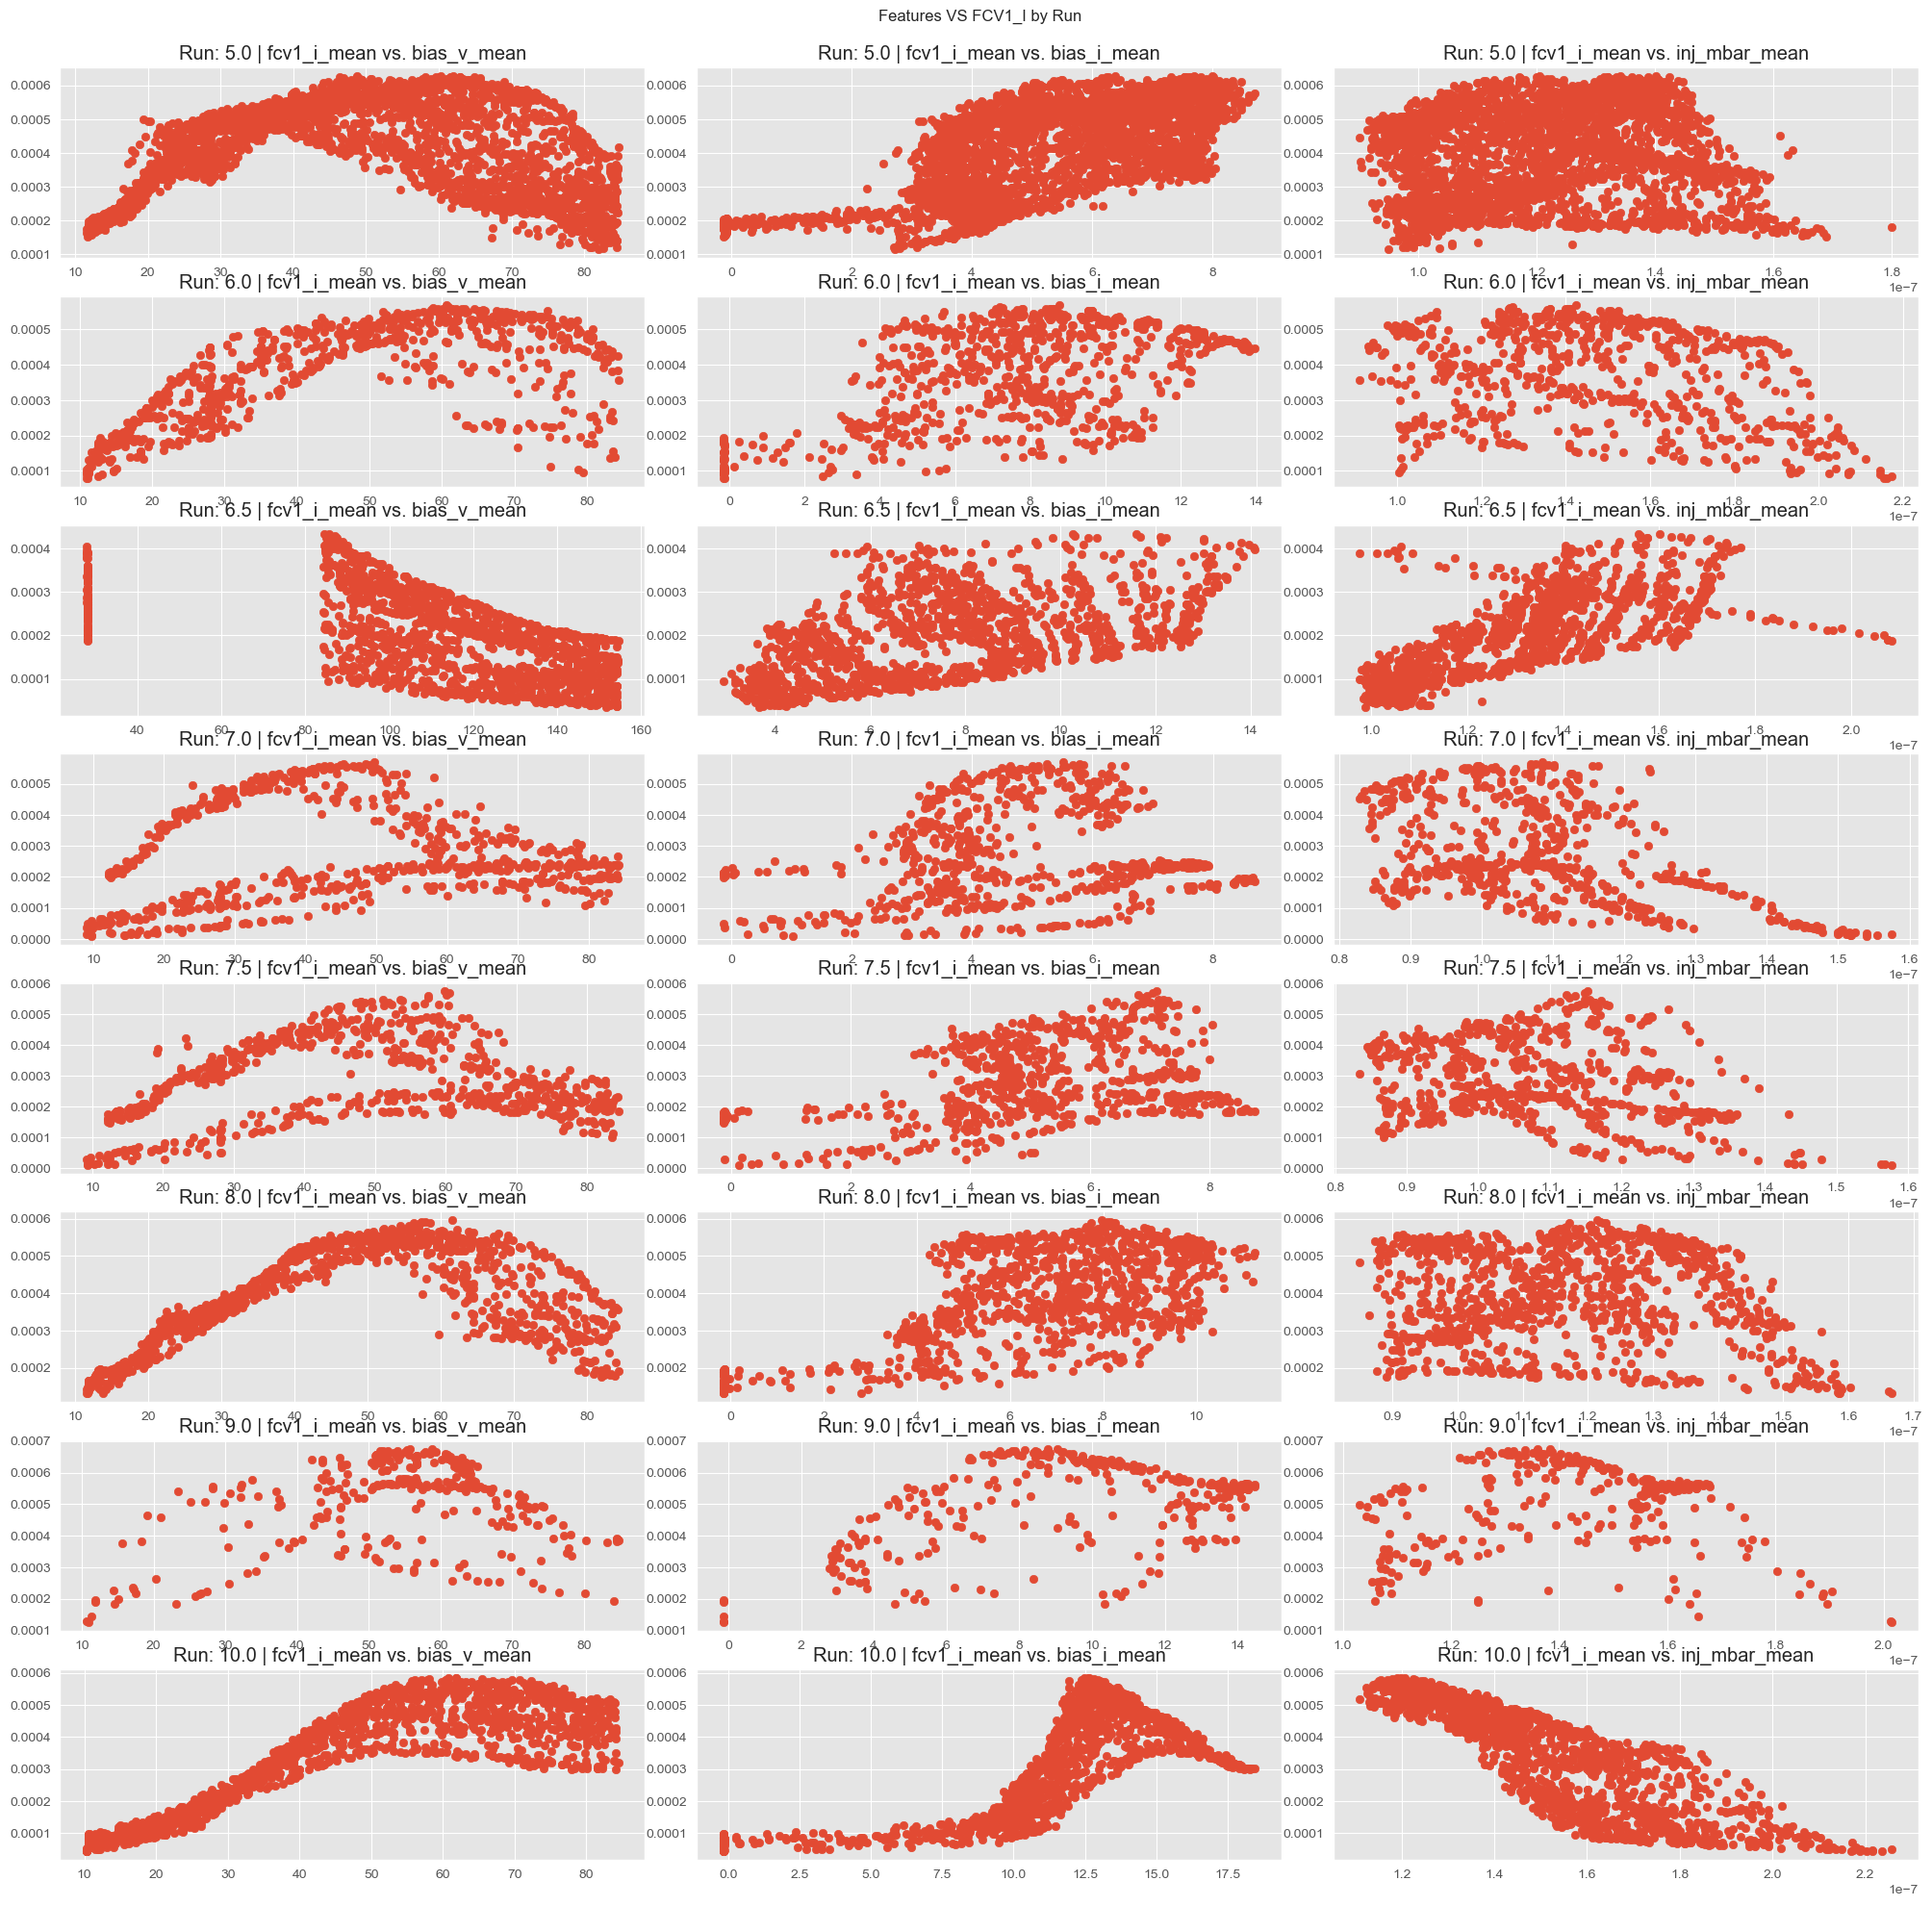

In [5]:
fig, axes= plt.subplots(8, 3, figsize=(20, 20))
fig.tight_layout()
for run_num, run in enumerate(tiny_df['run_id'].unique()):
    run_data = tiny_df[tiny_df['run_id'] == run]
    for i, feature in enumerate(features[1:]):
        x = run_data[feature]
        y = run_data['fcv1_i_mean']
        axes[run_num, i].scatter(x, y)
        axes[run_num, i].title.set_text(f"Run: {run} | fcv1_i_mean vs. {feature}")
fig.suptitle("Features VS FCV1_I by Run")
fig.subplots_adjust(top=0.95)
plt.show()

In [6]:
df['run_id'].value_counts()

run_id
5.0     3556
10.0    1637
6.5     1536
8.0     1181
6.0      774
7.5      748
7.0      713
9.0      309
Name: count, dtype: int64

Run 5 and Run 10 give the clearest pattern, probably due to having longer run length, although 10 is significantly less noisy than 6.5 which has a similar run length to 10.

### Key Features and Output Current over Runs

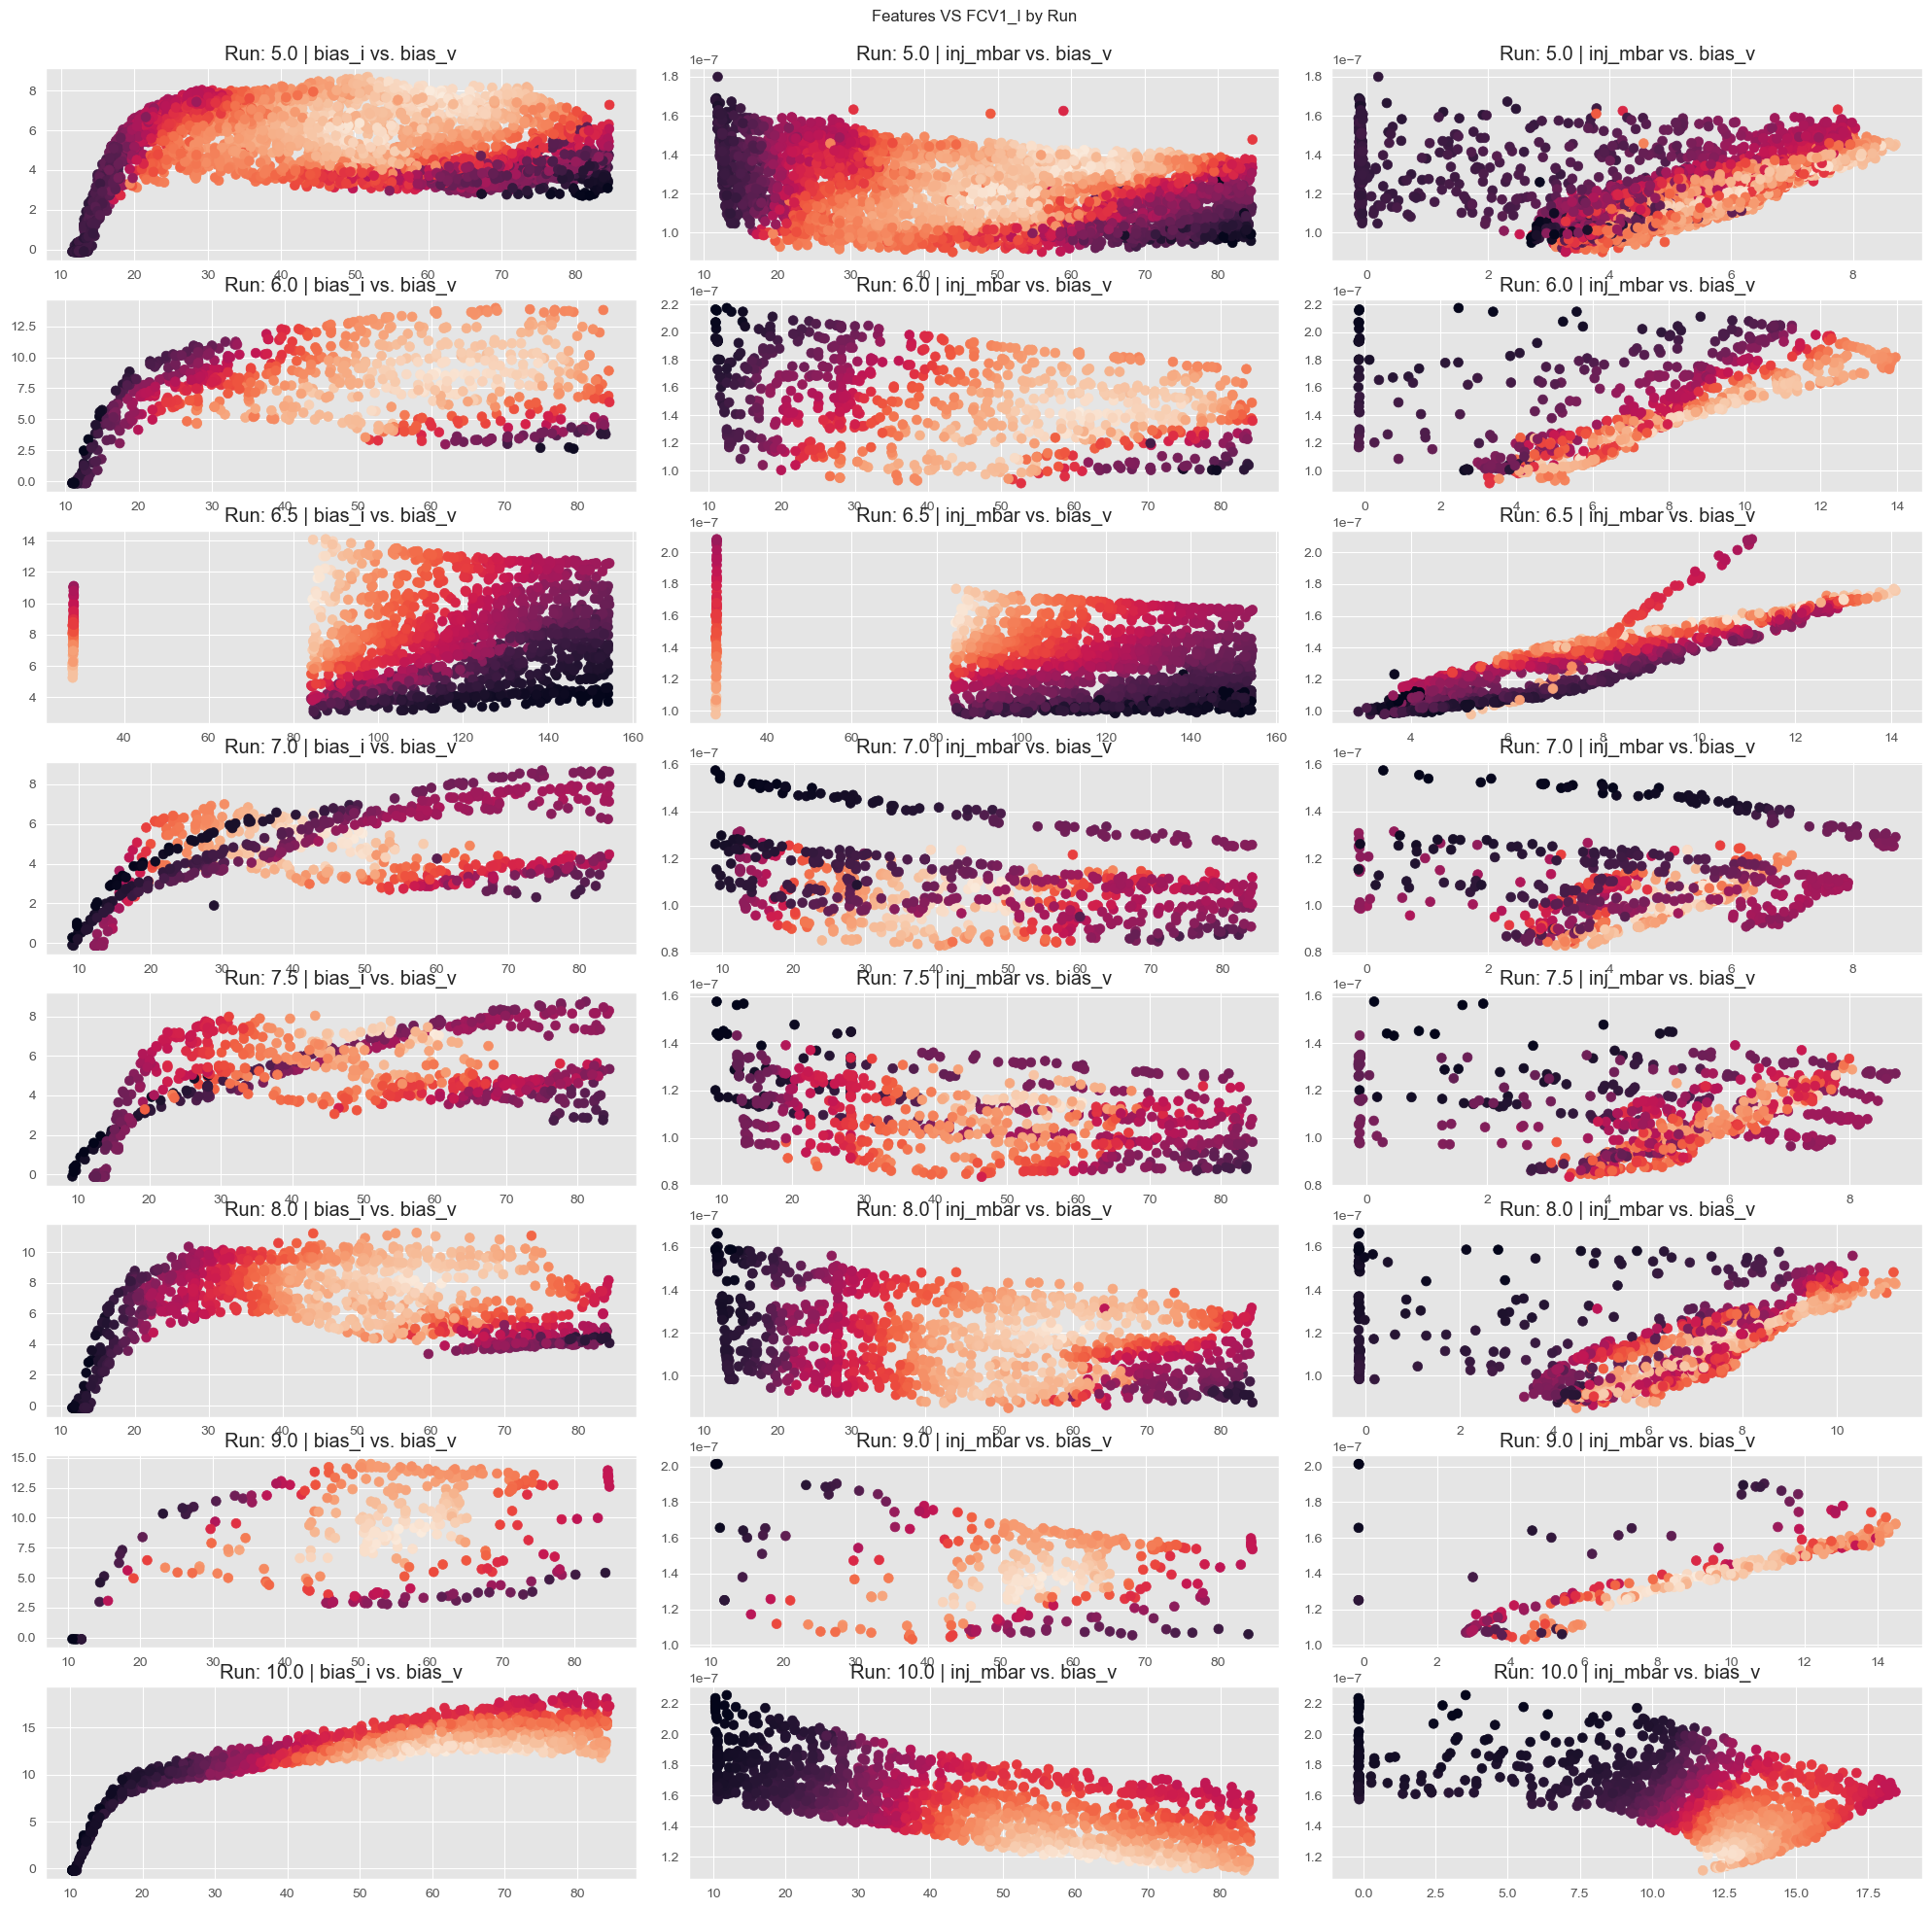

In [7]:
fig, axes= plt.subplots(8, 3, figsize=(20, 20))
fig.tight_layout()
for run_num, run in enumerate(tiny_df['run_id'].unique()):
    run_data = tiny_df[tiny_df['run_id'] == run]
    bias_v = run_data["bias_v_mean"]
    bias_i = run_data["bias_i_mean"]
    inj_mbar = run_data["inj_mbar_mean"]
    fcv1_i = run_data["fcv1_i_mean"]
    axes[run_num, 0].scatter(bias_v, bias_i, s=50, c=fcv1_i)
    axes[run_num, 0].title.set_text(f"Run: {run} | bias_i vs. bias_v")
    axes[run_num, 1].scatter(bias_v, inj_mbar, s=50, c=fcv1_i)
    axes[run_num, 1].title.set_text(f"Run: {run} | inj_mbar vs. bias_v")
    axes[run_num, 2].scatter(bias_i, inj_mbar, s=50, c=fcv1_i)
    axes[run_num, 2].title.set_text(f"Run: {run} | inj_mbar vs. bias_v")
fig.suptitle("Features VS FCV1_I by Run")
fig.subplots_adjust(top=0.95)
plt.show()

### Comparing data ranges between runs

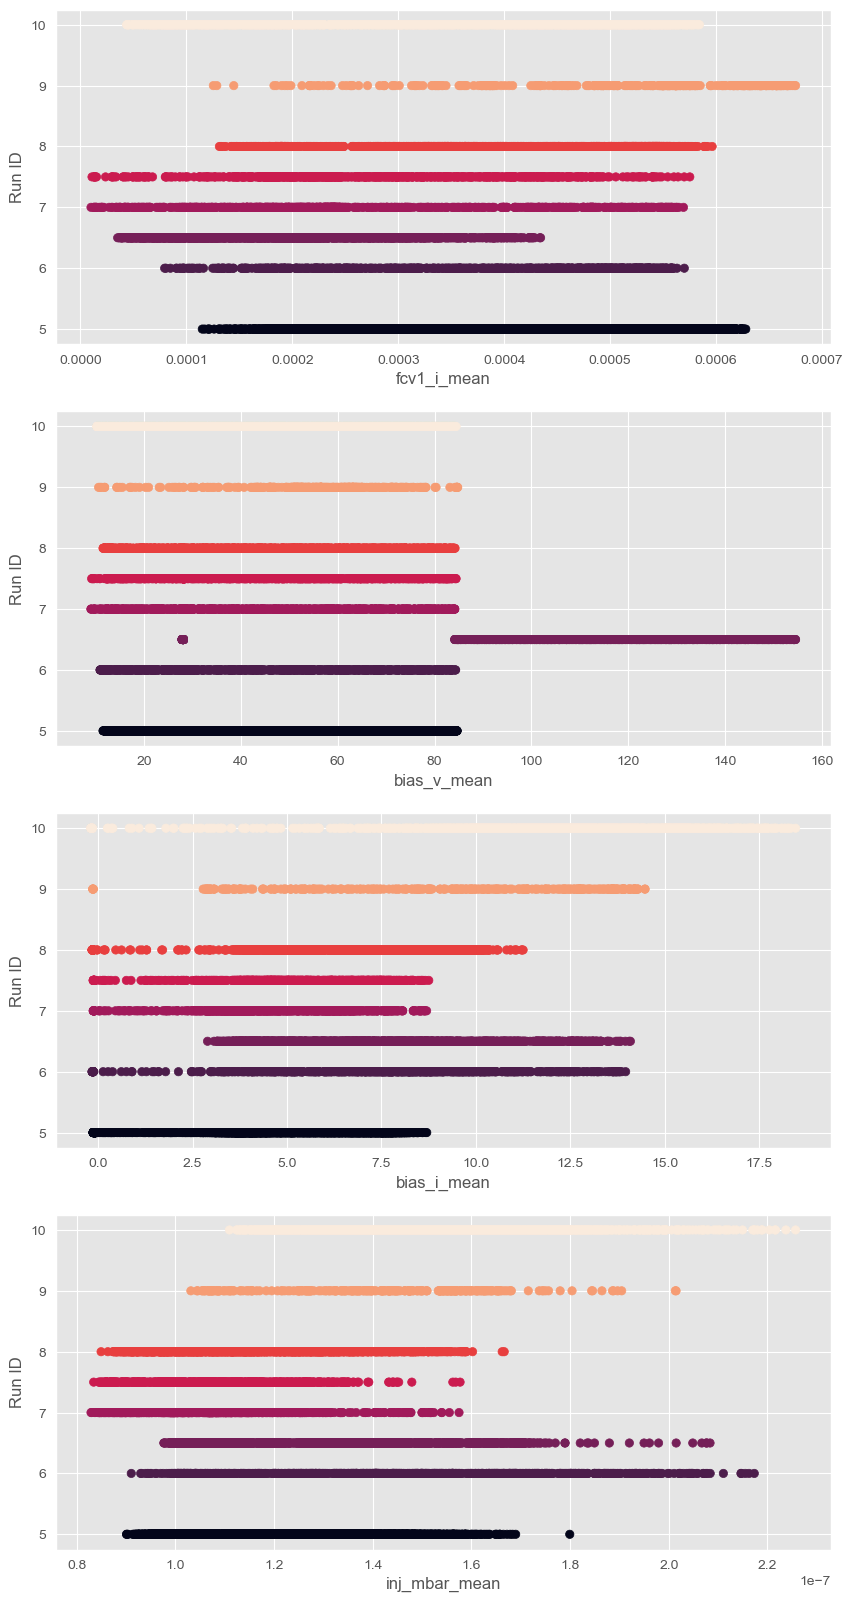

In [8]:
fig, axes = plt.subplots(4, 1, figsize=(10, 20))
for i, feature in enumerate(features):
    feature_data = tiny_df[feature]
    axes[i].scatter(feature_data, tiny_df["run_id"], c=tiny_df["run_id"])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Run ID")

In [9]:
print(*tiny_df["run_id"].unique(), sep=", ")

5.0, 6.0, 6.5, 7.0, 7.5, 8.0, 9.0, 10.0


# Full Dataset Feature Importance via RandomForestRegressor
Just to see, better to go run by run b/c of tuning between runs. Uses values generated by sklearn RandomForestRegressor, aka Gini importance

In [10]:
target = df["fcv1_i_mean"]
dropped = df.drop(["fcv1_i_mean", "start_time", "stop_time", "run_id", "time_mean", "time_std", "unix_epoch_milliseconds_mean", "unix_epoch_milliseconds_std"],axis=1)
not_mean = lambda string: string.find("_std") < 0
feature_means = dropped[filter(not_mean, dropped.columns)]

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
model = RandomForestRegressor(random_state=1931)
_ = model.fit(feature_means, target)

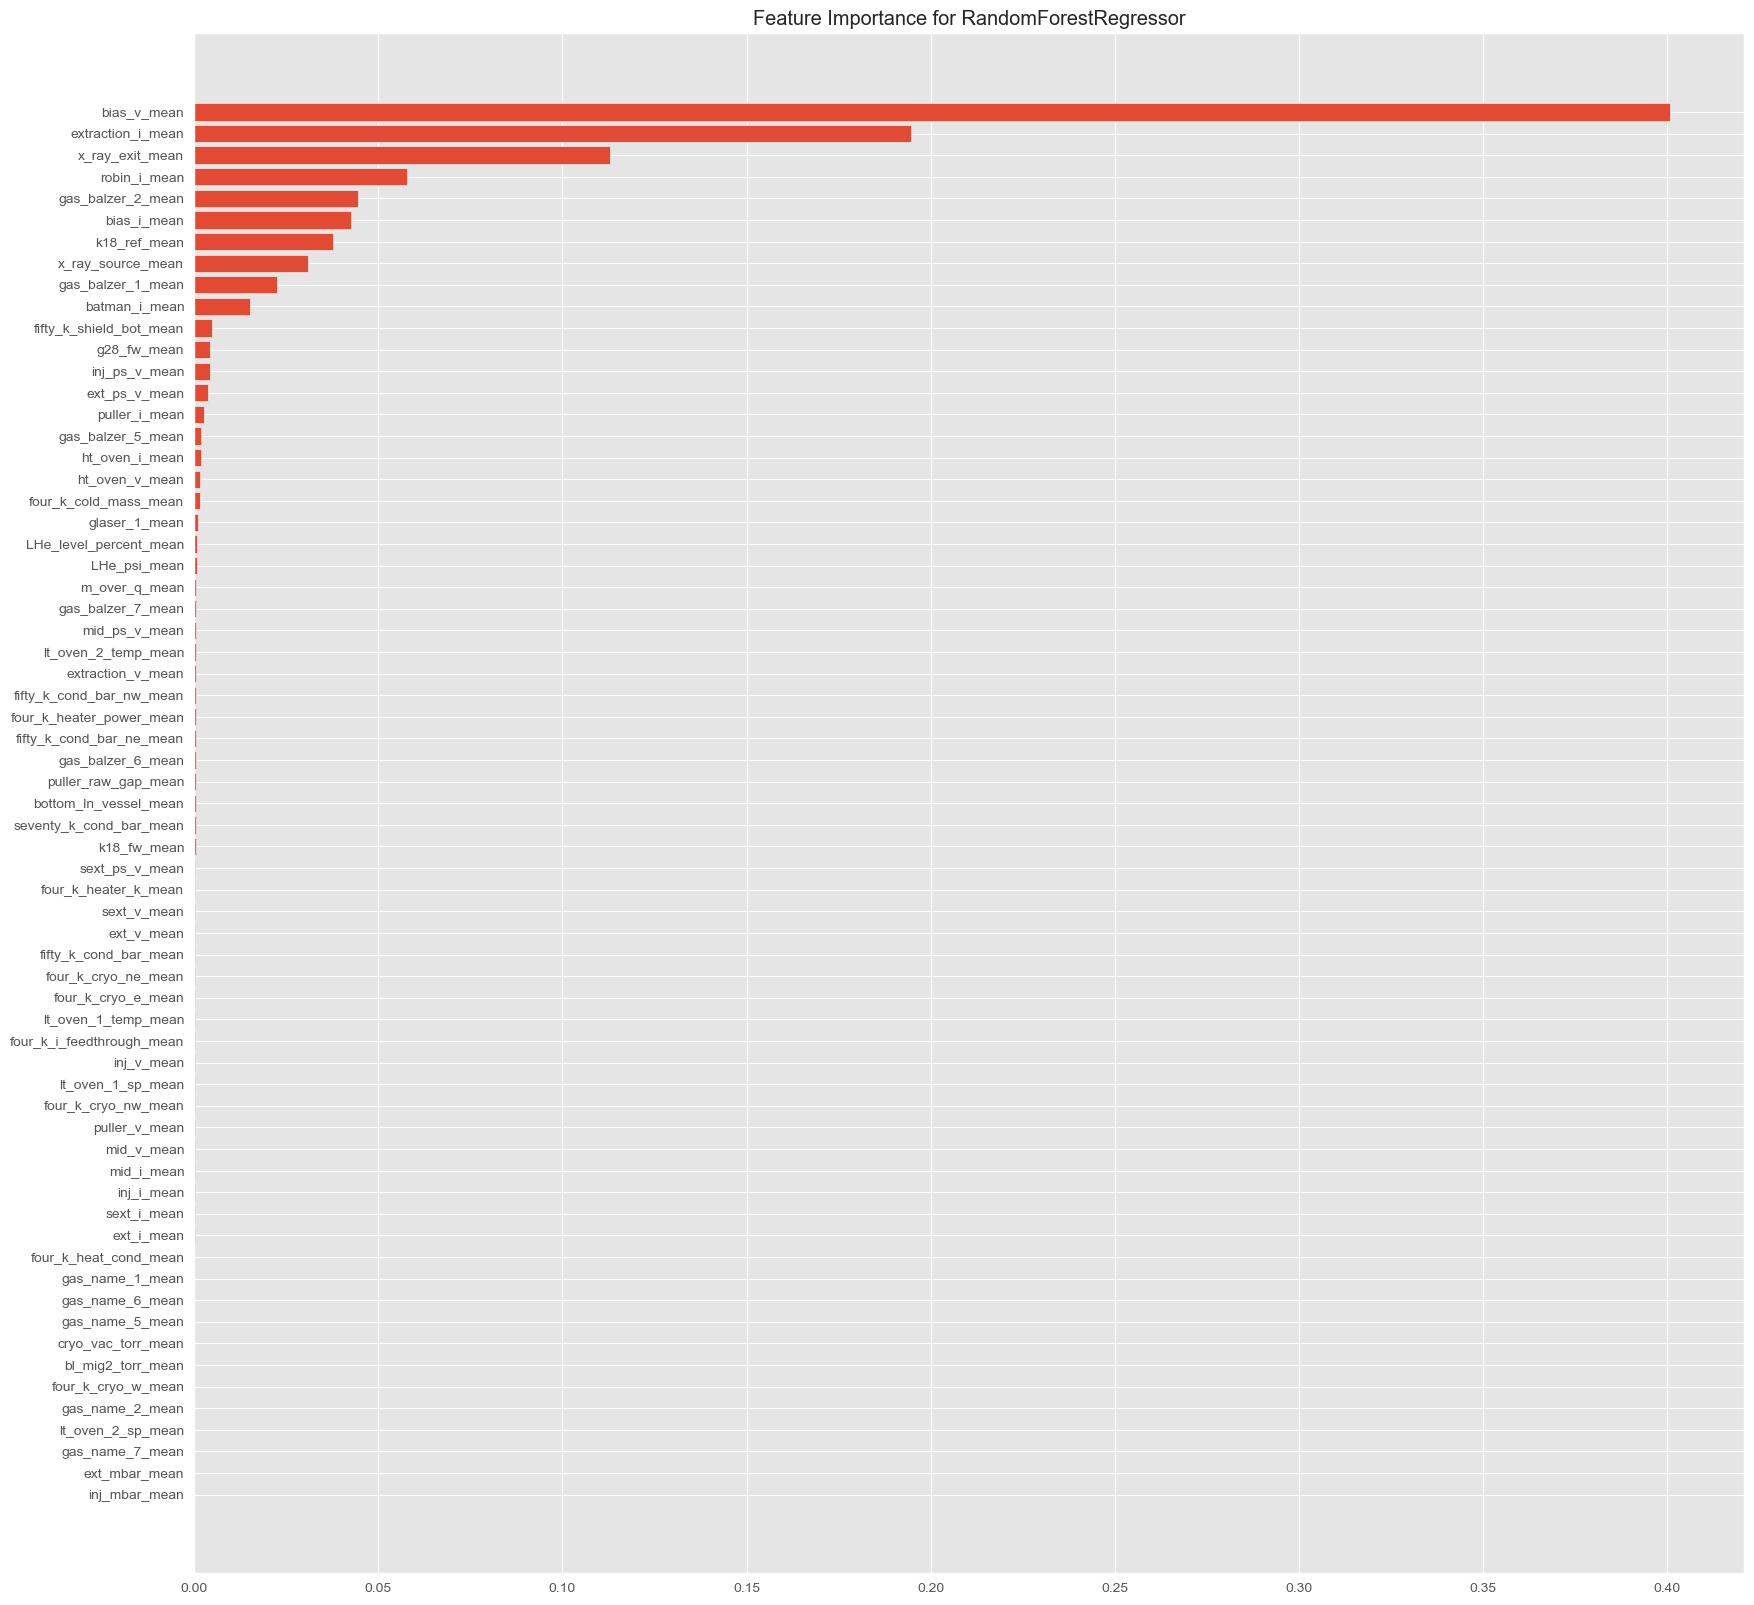

In [12]:
importances = model.feature_importances_
sorted_idx = np.argsort(importances)
padding = np.arange(len(sorted_idx)) + 0.5
plt.figure(figsize=(20, 20))
plt.barh(padding, importances[sorted_idx])
plt.yticks(padding, feature_means.columns[sorted_idx])
plt.title("Feature Importance for RandomForestRegressor")
plt.show()

In [13]:
for i, f in enumerate(feature_means.columns[sorted_idx[::-1]][:10]):
    print(i+1, f)

1 bias_v_mean
2 extraction_i_mean
3 x_ray_exit_mean
4 robin_i_mean
5 gas_balzer_2_mean
6 bias_i_mean
7 k18_ref_mean
8 x_ray_source_mean
9 gas_balzer_1_mean
10 batman_i_mean


Calculating permuation importances, more resistant to "high cardinality features", i.e. if certain settings are drastically altered between runs
https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance

In [14]:
perm_importances = permutation_importance(model, feature_means, target, n_repeats=10)

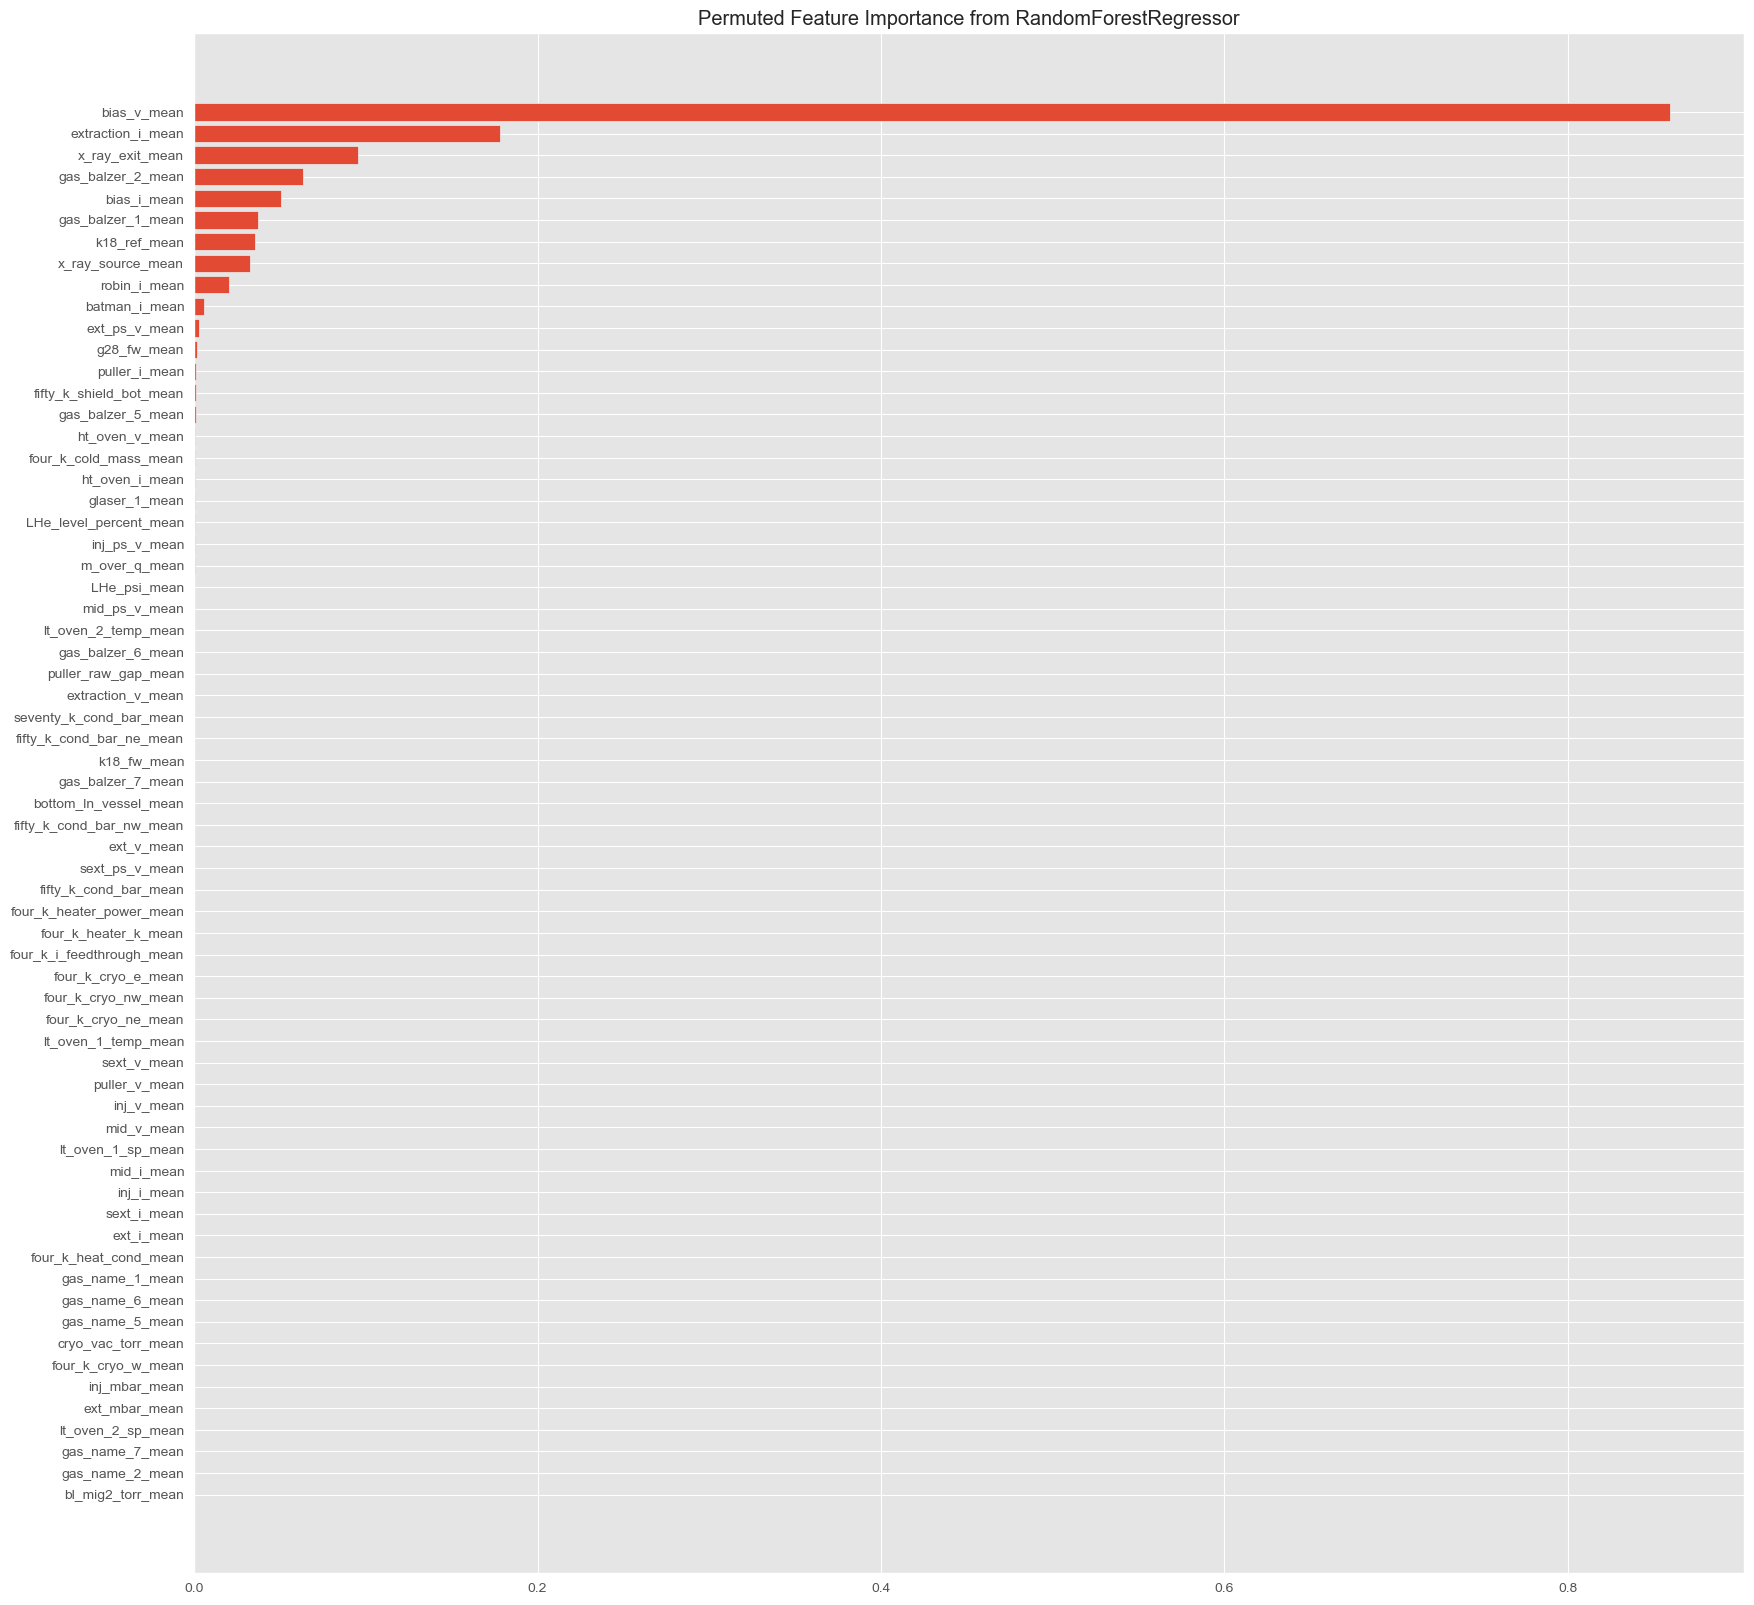

In [15]:
importances = perm_importances.importances_mean
sorted_idx = np.argsort(importances)
padding = np.arange(len(sorted_idx)) + 0.5
plt.figure(figsize=(20, 20))
plt.barh(padding, importances[sorted_idx])
plt.yticks(padding, feature_means.columns[sorted_idx])
plt.title("Permuted Feature Importance from RandomForestRegressor")
plt.show()

In [16]:
for i, f in enumerate(feature_means.columns[sorted_idx[::-1]][:10]):
    print(i+1, f)

1 bias_v_mean
2 extraction_i_mean
3 x_ray_exit_mean
4 gas_balzer_2_mean
5 bias_i_mean
6 gas_balzer_1_mean
7 k18_ref_mean
8 x_ray_source_mean
9 robin_i_mean
10 batman_i_mean


# Run Feature Importance via RandomForestRegressor

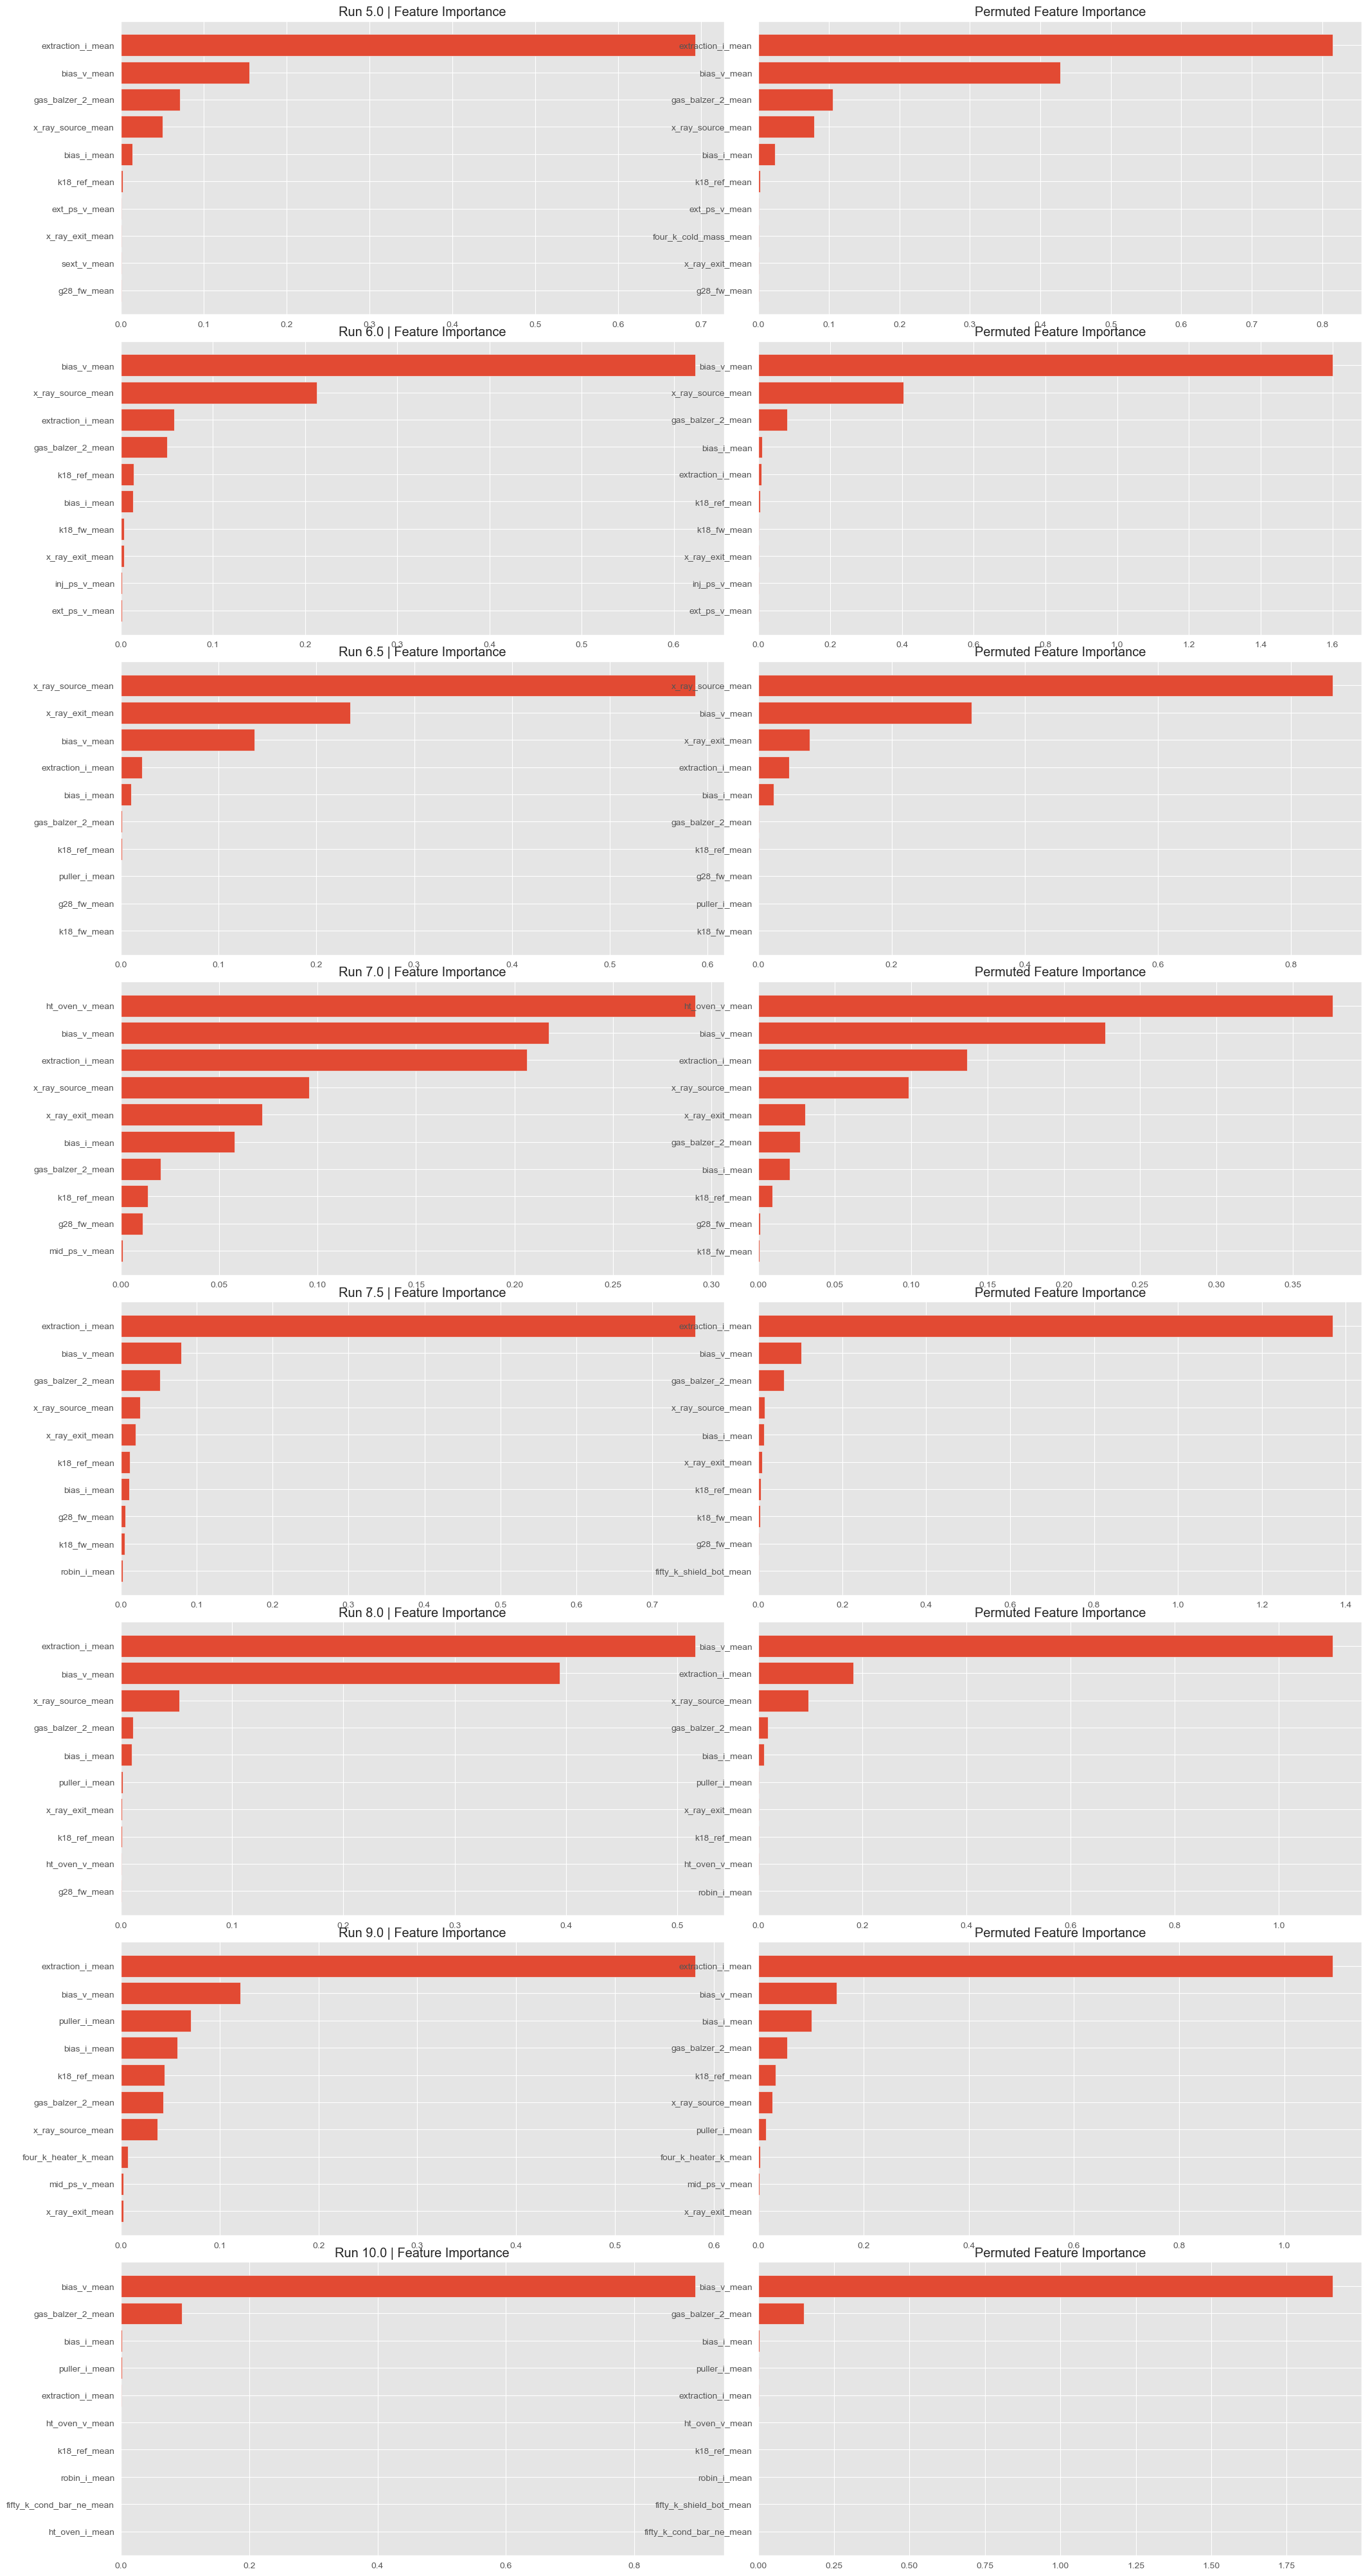

In [17]:
top_k = 10
fig, axes = plt.subplots(8, 2, figsize=(20,40))
fig.tight_layout()
for i, run in enumerate(df['run_id'].unique()):
    run_data = df[df['run_id'] == run]
    targets = run_data['fcv1_i_mean']
    features = run_data.drop(["fcv1_i_mean", "start_time", "stop_time", "run_id", "time_mean", "time_std", "unix_epoch_milliseconds_mean", "unix_epoch_milliseconds_std"],axis=1)
    features = features[filter(not_mean, dropped.columns)]

    model = RandomForestRegressor(random_state=1931)
    model.fit(features, targets)
    pairs = list(zip(features,model.feature_importances_))
    pairs.sort(key = lambda x : x[1])
    pairs = pairs[-top_k:]
    axes[i, 0].barh([x[0] for x in pairs], [x[1] for x in pairs])
    axes[i, 0].title.set_text(f"Run {run} | Feature Importance")

    perm_importances = permutation_importance(model, features, targets)
    pairs = list(zip(features, perm_importances.importances_mean))
    pairs.sort(key = lambda x : x[1])
    pairs = pairs[-top_k:]
    axes[i, 1].barh([x[0] for x in pairs], [x[1] for x in pairs])
    axes[i, 1].title.set_text(f"Permuted Feature Importance")


plt.show()

The most important features seem to switch around depending on the run, with bias_v and extraction_i consistently in of the most important features according to the random forest. The importance is just a value associated with how well that feature helped the random forest make its splits more pure, so it doesn't fully represent what features cause a certain beam current, only what helped this model predict it.

# Stability (fcv1_std)

In [31]:
rows = ["run_id", 'fcv1_i_mean', "fcv1_i_std", "bias_v_mean", "bias_i_mean", "inj_mbar_mean", "start_time", "stop_time"]
features = rows[2:6]
tiny_df = df[rows]
tiny_df

run_id  fcv1_i_mean    fcv1_i_std  bias_v_mean  bias_i_mean  \
2490      5.0     0.000408  2.433364e-06    30.367090     7.752190   
2491      5.0     0.000182  3.099090e-06    11.886959     0.191699   
2492      5.0     0.000416  3.805828e-06    84.668518     7.286177   
2493      5.0     0.000357  1.284951e-05    84.572268     5.439768   
2494      5.0     0.000196  6.417673e-06    84.459976     4.143592   
...       ...          ...           ...          ...          ...   
12939    10.0     0.000131  1.326179e-06    23.749855    10.338125   
12940    10.0     0.000433  8.247169e-06    64.127014    15.736986   
12941    10.0     0.000136  1.073817e-06    24.086733    10.366198   
12942    10.0     0.000074  5.137060e-07    12.825403     3.896548   
12943    10.0     0.000182  2.348973e-06    28.570410    11.057599   

       inj_mbar_mean    start_time     stop_time  
2490    1.631546e-07  1.662167e+09  1.662167e+09  
2491    1.799325e-07  1.662167e+09  1.662168e+09  
2492    1.477675e-07  1.662168e+09  1.662168e+09  
2493    1.352869e-07  1.662168e+09  1.662168e+09  
2494    1.118232e-07  1.662169e+09  1.662169e+09  
...              ...           ...           ...  
12939   1.779659e-07  1.672848e+09  1.672848e+09  
12940   1.440222e-07  1.672848e+09  1.672848e+09  
12941   1.768910e-07  1.672848e+09  1.672848e+09  
12942   1.875515e-07  1.672848e+09  1.672848e+09  
12943   1.743328e-07  1.672848e+09  1.672848e+09  

[10454 rows x 8 columns]

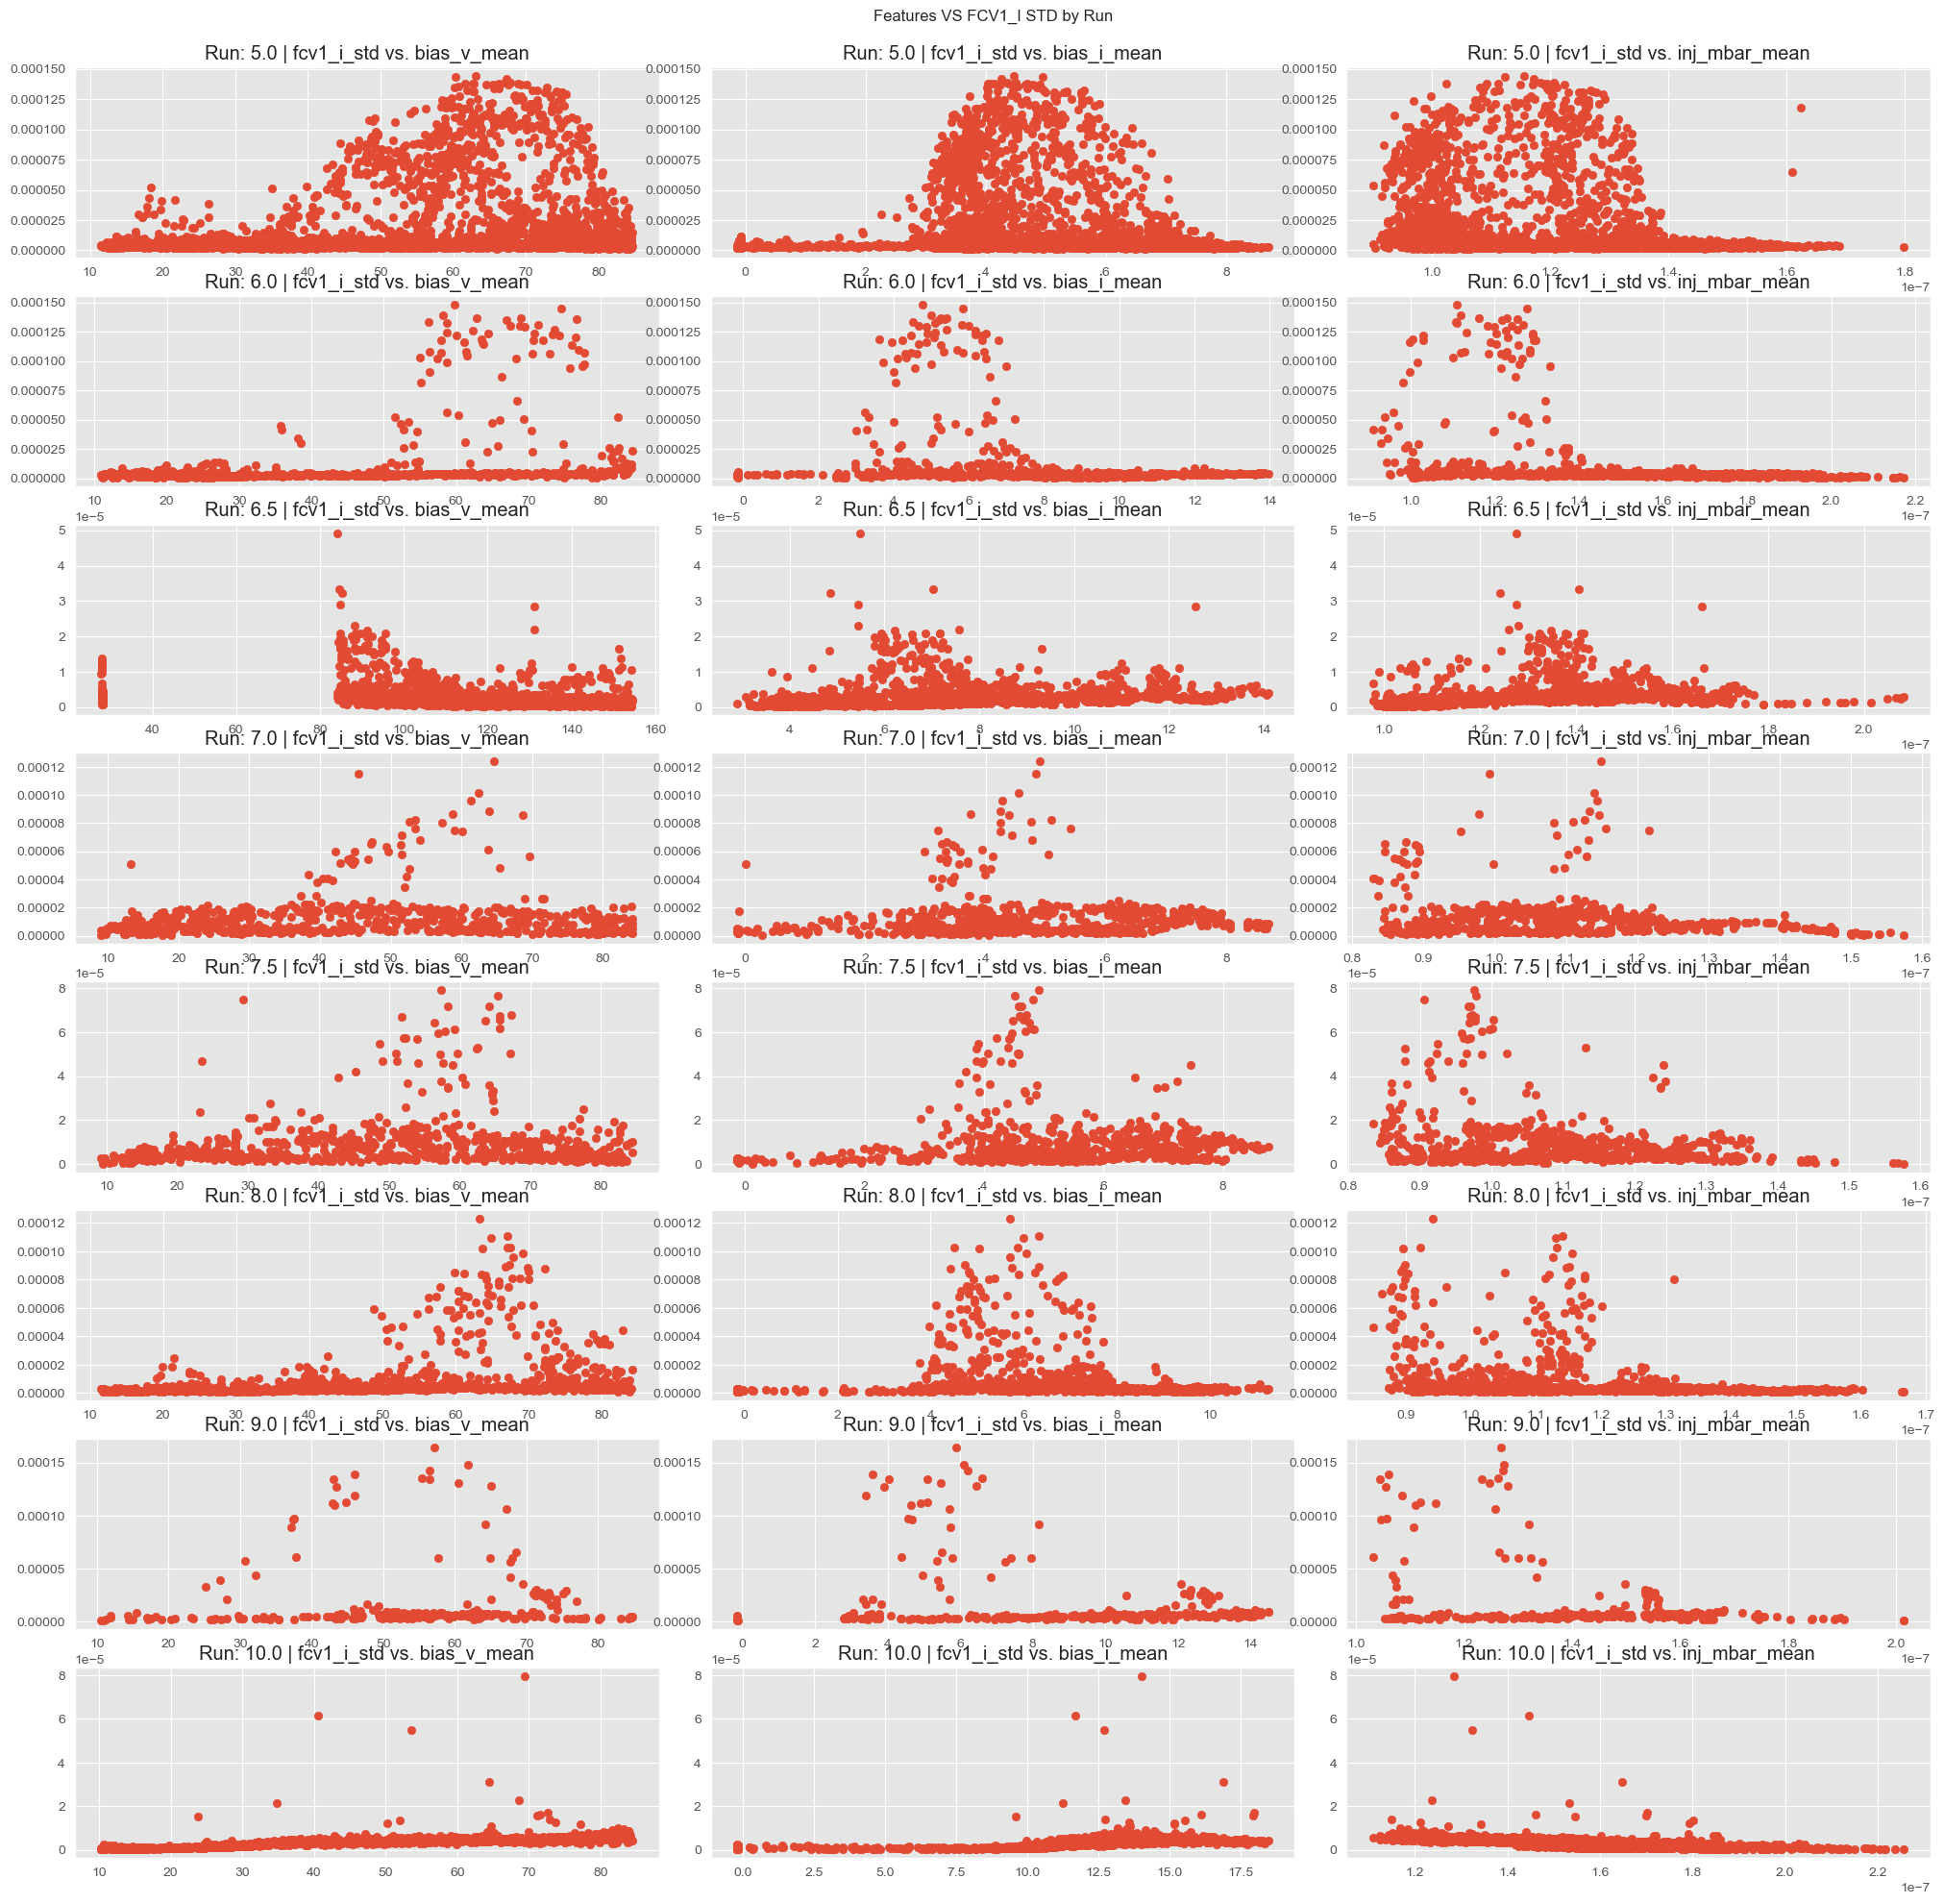

In [32]:
fig, axes= plt.subplots(8, 3, figsize=(20, 20))
fig.tight_layout()
for run_num, run in enumerate(tiny_df['run_id'].unique()):
    run_data = tiny_df[tiny_df['run_id'] == run]
    for i, feature in enumerate(features[1:]):
        x = run_data[feature]
        y = run_data['fcv1_i_std']
        axes[run_num, i].scatter(x, y)
        axes[run_num, i].title.set_text(f"Run: {run} | fcv1_i_std vs. {feature}")
fig.suptitle("Features VS FCV1_I STD by Run")
fig.subplots_adjust(top=0.95)
plt.show()

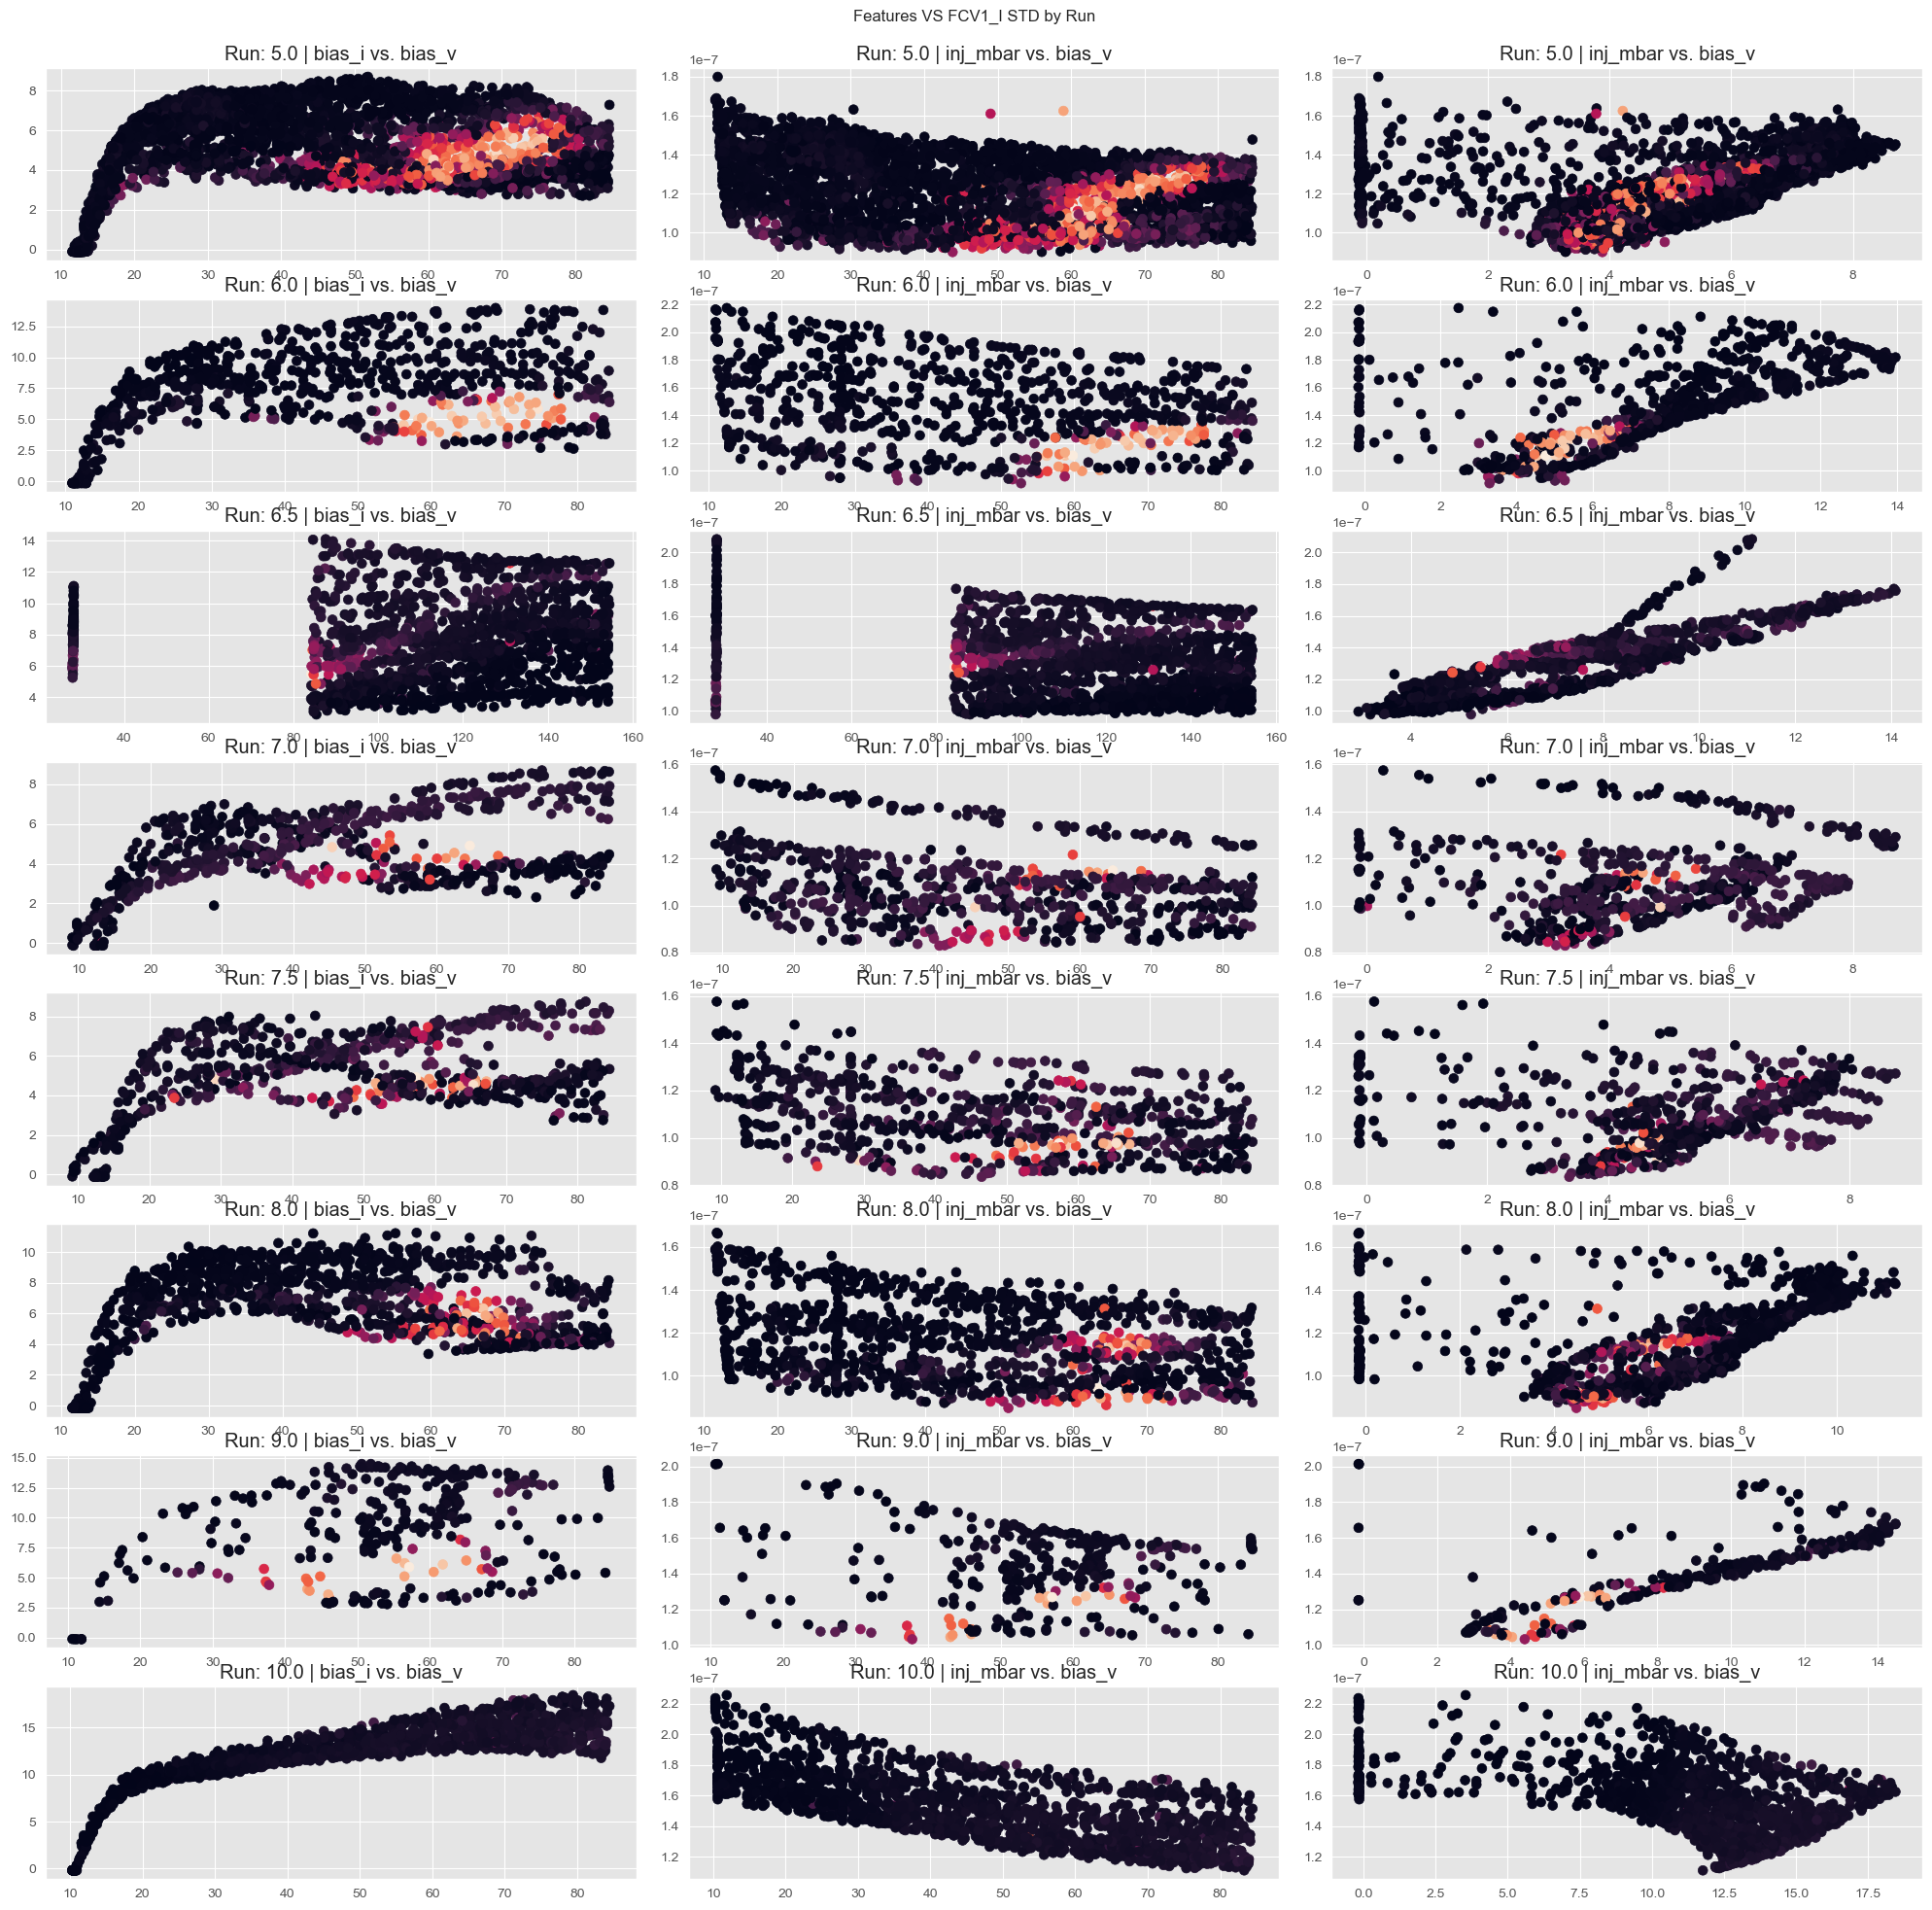

In [27]:
fig, axes= plt.subplots(8, 3, figsize=(20, 20))
fig.tight_layout()
for run_num, run in enumerate(tiny_df['run_id'].unique()):
    run_data = tiny_df[tiny_df['run_id'] == run]
    bias_v = run_data["bias_v_mean"]
    bias_i = run_data["bias_i_mean"]
    inj_mbar = run_data["inj_mbar_mean"]
    fcv1_i = run_data["fcv1_i_std"]
    axes[run_num, 0].scatter(bias_v, bias_i, s=50, c=fcv1_i)
    axes[run_num, 0].title.set_text(f"Run: {run} | bias_i vs. bias_v")
    axes[run_num, 1].scatter(bias_v, inj_mbar, s=50, c=fcv1_i)
    axes[run_num, 1].title.set_text(f"Run: {run} | inj_mbar vs. bias_v")
    axes[run_num, 2].scatter(bias_i, inj_mbar, s=50, c=fcv1_i)
    axes[run_num, 2].title.set_text(f"Run: {run} | inj_mbar vs. bias_v")
fig.suptitle("Features VS FCV1_I STD by Run")
fig.subplots_adjust(top=0.95)
plt.show()

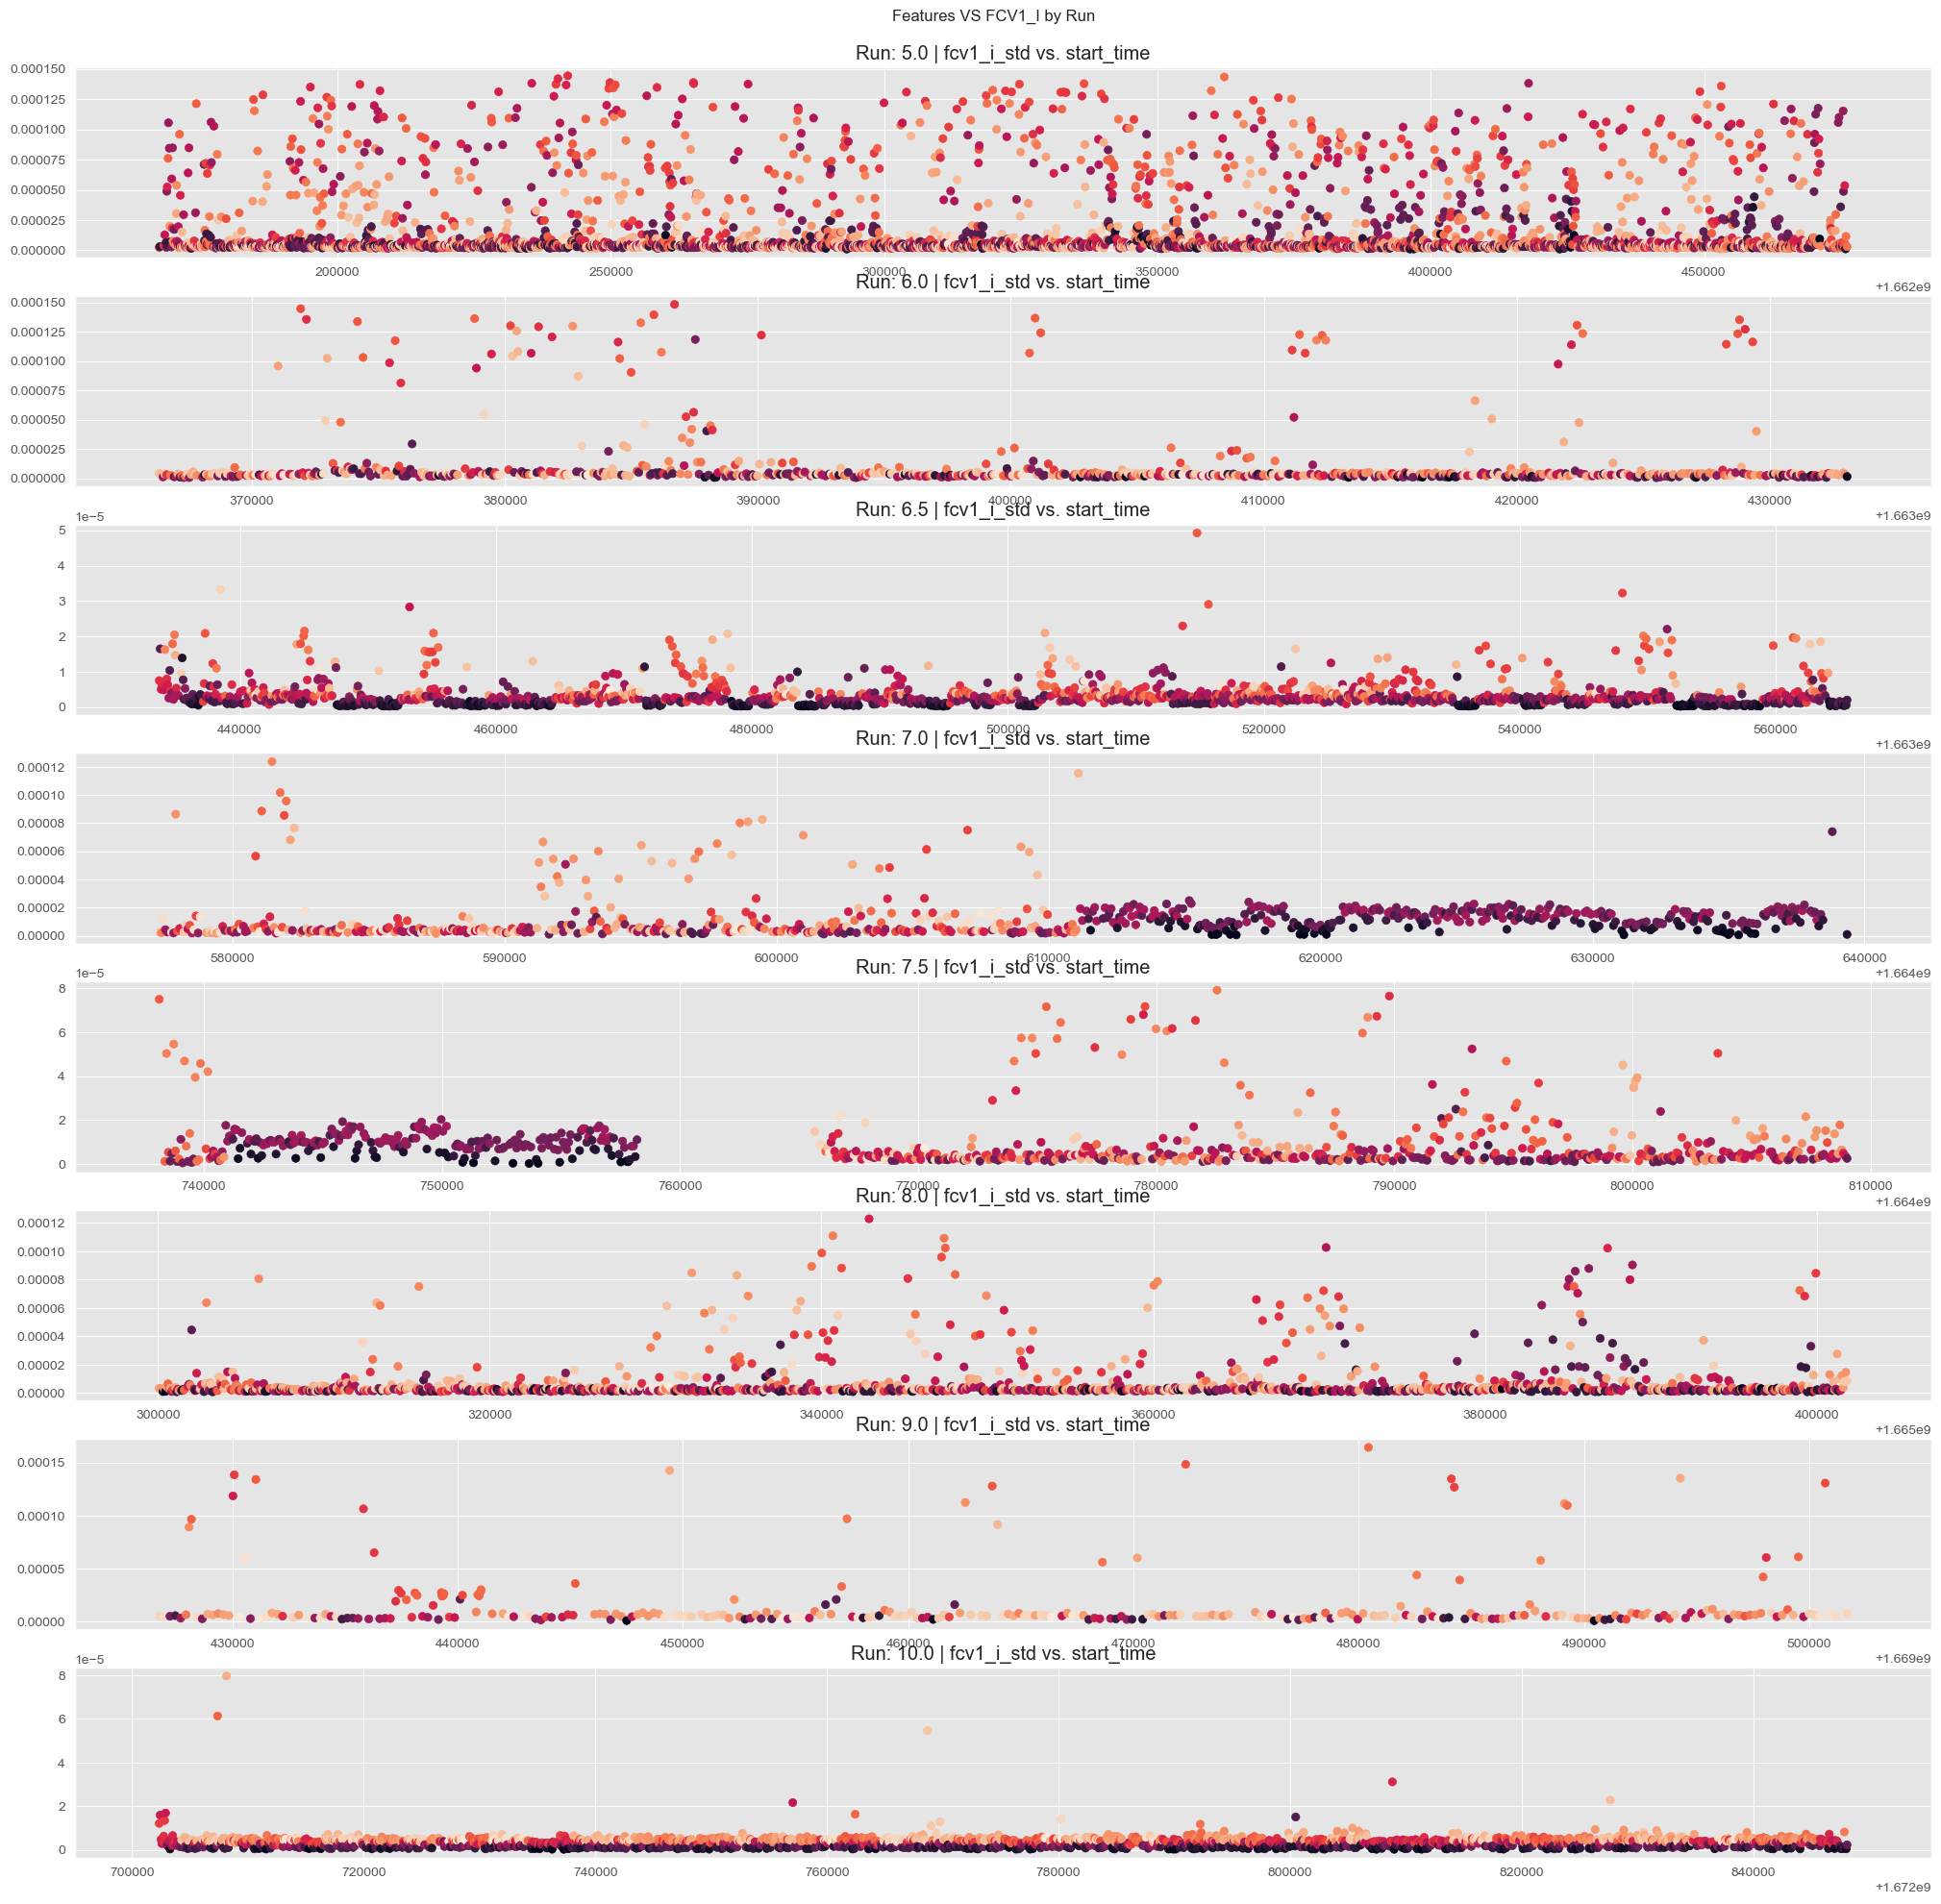

In [33]:
fig, axes= plt.subplots(8, 1, figsize=(20, 20))
fig.tight_layout()
for run_num, run in enumerate(tiny_df['run_id'].unique()):
    run_data = tiny_df[tiny_df['run_id'] == run]
    x = run_data["start_time"]
    y = run_data['fcv1_i_std']
    color = run_data['fcv1_i_mean']
    axes[run_num].scatter(x, y, c=color)
    axes[run_num].title.set_text(f"Run: {run} | fcv1_i_std vs. start_time")
fig.suptitle("Features VS FCV1_I by Run")
fig.subplots_adjust(top=0.95)
plt.show()

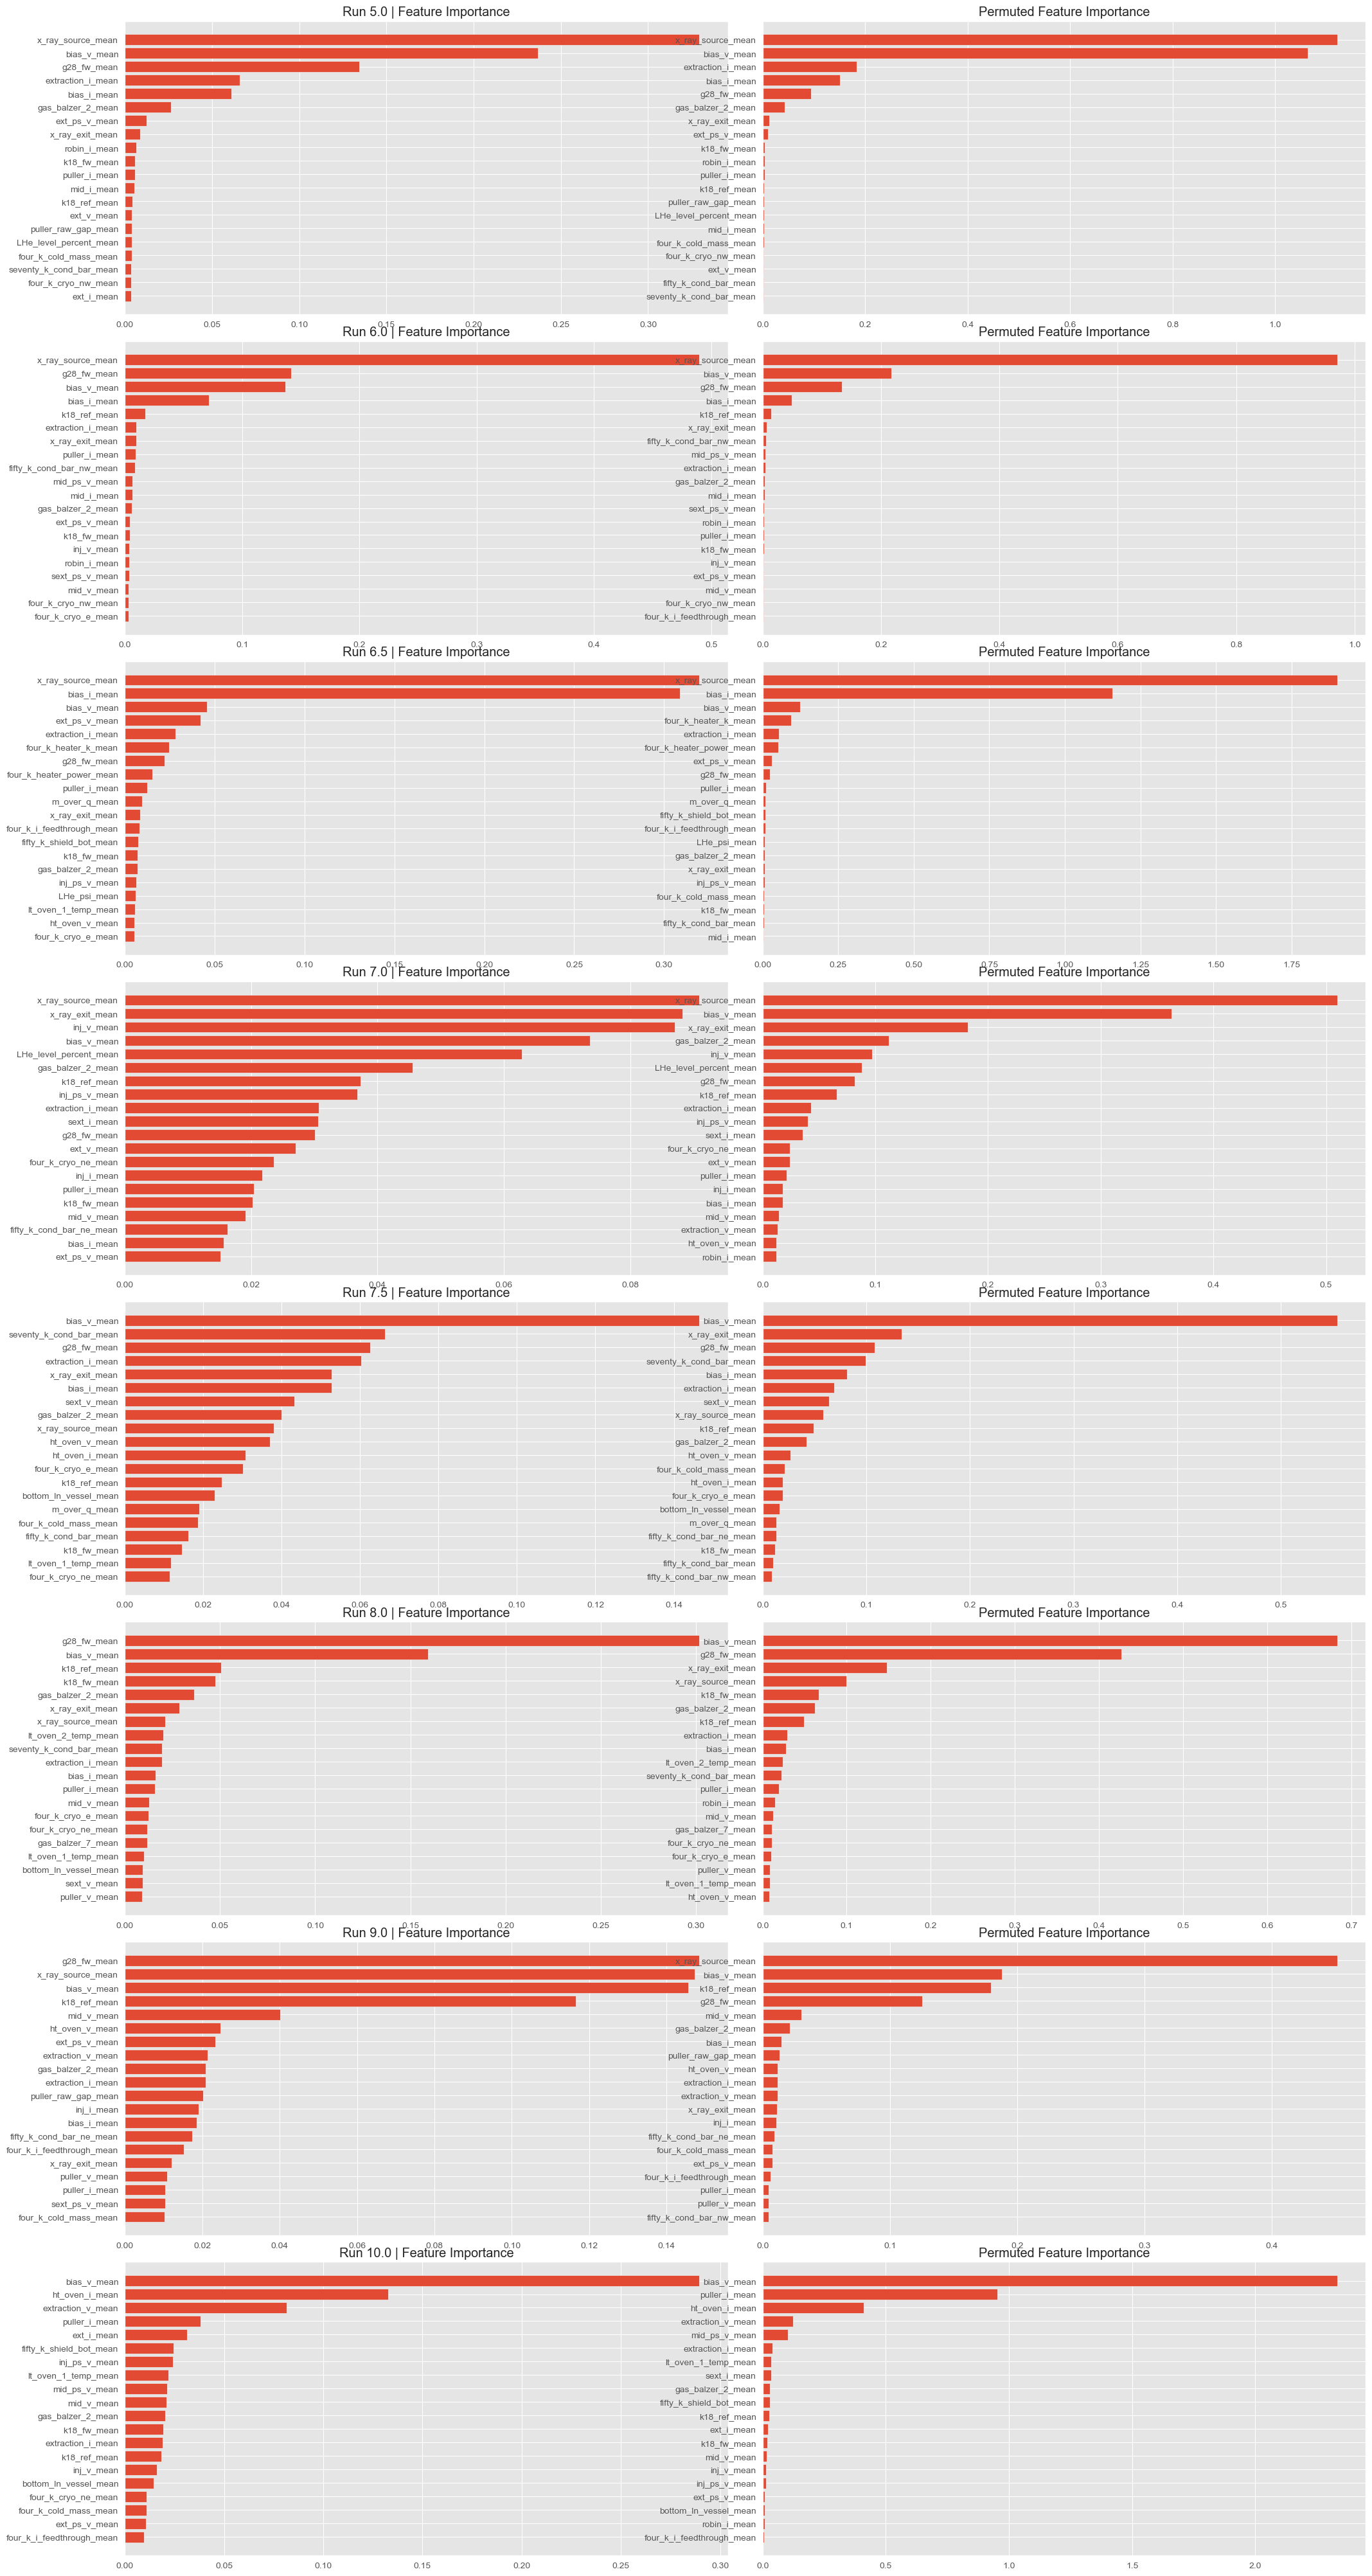

In [36]:
top_k = 20
fig, axes = plt.subplots(8, 2, figsize=(20,40))
fig.tight_layout()
for i, run in enumerate(df['run_id'].unique()):
    run_data = df[df['run_id'] == run]
    targets = run_data['fcv1_i_std']
    features = run_data.drop(["fcv1_i_std", "start_time", "stop_time", "run_id", "time_mean", "time_std", "unix_epoch_milliseconds_mean", "unix_epoch_milliseconds_std"],axis=1)
    features = features[filter(not_mean, dropped.columns)]

    model = RandomForestRegressor(random_state=1931)
    model.fit(features, targets)
    pairs = list(zip(features,model.feature_importances_))
    pairs.sort(key = lambda x : x[1])
    pairs = pairs[-top_k:]
    axes[i, 0].barh([x[0] for x in pairs], [x[1] for x in pairs])
    axes[i, 0].title.set_text(f"Run {run} | Feature Importance")

    perm_importances = permutation_importance(model, features, targets)
    pairs = list(zip(features, perm_importances.importances_mean))
    pairs.sort(key = lambda x : x[1])
    pairs = pairs[-top_k:]
    axes[i, 1].barh([x[0] for x in pairs], [x[1] for x in pairs])
    axes[i, 1].title.set_text(f"Permuted Feature Importance")


plt.show()